# **SEL-NNML Tuning - UCI Heart Disease Dataset**

This notebook implements several tuning methods on the `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model using the `UCI Heart Disease Dataset (UCHDD)`.

## **0. Global Configuration**

In [ ]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'
OPTIMIZATION_DIRECTION='maximize'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../datasets/processed/ds2_uci_heart_clean.csv'
TARGET_COLUMN = 'num'

# Training configuration
SKIP_TRAINING = True  # Set to True to load pre-existing models instead of training

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')
print(f'Optimization Direction: {OPTIMIZATION_DIRECTION}')
print(f'Skip Training: {SKIP_TRAINING}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy
Optimization Direction: maximize
Skip Training: False


## **1. Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from src import base_model_tuning, meta_model_tuning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

## **2. Load Dataset**

In [3]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    bool   
 2   trestbps   297 non-null    int64  
 3   chol       297 non-null    int64  
 4   fbs        297 non-null    bool   
 5   thalach    297 non-null    int64  
 6   exang      297 non-null    bool   
 7   oldpeak    297 non-null    float64
 8   num        297 non-null    bool   
 9   cp_1       297 non-null    bool   
 10  cp_2       297 non-null    bool   
 11  cp_3       297 non-null    bool   
 12  cp_4       297 non-null    bool   
 13  restecg_0  297 non-null    bool   
 14  restecg_1  297 non-null    bool   
 15  restecg_2  297 non-null    bool   
 16  slope_1    297 non-null    bool   
 17  slope_2    297 non-null    bool   
 18  slope_3    297 non-null    bool   
 19  ca_0.0     297 non-null    bool   
 20  ca_1.0    

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num,cp_1,...,slope_1,slope_2,slope_3,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
0,63,True,145,233,True,150,False,2.3,False,True,...,False,False,True,True,False,False,False,False,True,False
1,67,True,160,286,False,108,True,1.5,True,False,...,False,True,False,False,False,False,True,True,False,False
2,67,True,120,229,False,129,True,2.6,True,False,...,False,True,False,False,False,True,False,False,False,True
3,37,True,130,250,False,187,False,3.5,False,False,...,False,False,True,True,False,False,False,True,False,False
4,41,False,130,204,False,172,False,1.4,False,False,...,True,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,False,140,241,False,123,True,0.2,True,False,...,False,True,False,True,False,False,False,False,False,True
293,45,True,110,264,False,132,False,1.2,True,True,...,False,True,False,True,False,False,False,False,False,True
294,68,True,144,193,True,141,False,3.4,True,False,...,False,True,False,False,False,True,False,False,False,True
295,57,True,130,131,False,115,True,1.2,True,False,...,False,True,False,False,True,False,False,False,False,True


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [4]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

# Save Min-Max Scaler
scaler_filename = '../artifacts/ds2/models/min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f'Saved Min-Max Scaler function for this dataset to {scaler_filename}')

Saved Min-Max Scaler function for this dataset to ../artifacts/ds2/models/min_max_scaler.pkl


In [6]:
X_train

,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang,cp_1,cp_2,...,slope_1,slope_2,slope_3,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
273,0.208333,0.415094,0.214612,0.618321,0.000000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False
259,0.645833,0.528302,0.260274,0.763359,0.160714,False,False,False,True,False,...,True,False,False,True,False,False,False,True,False,False
30,0.833333,0.433962,0.257991,0.610687,0.321429,False,False,False,True,False,...,True,False,False,False,False,True,False,True,False,False
22,0.604167,0.245283,0.360731,0.679389,0.321429,True,False,False,False,True,...,False,True,False,True,False,False,False,True,False,False
277,0.375000,0.339623,0.289954,0.824427,0.000000,True,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.437500,0.330189,0.159817,0.702290,0.000000,True,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
71,0.791667,0.292453,0.292237,0.702290,0.035714,True,True,False,False,False,...,False,True,False,False,False,True,False,False,False,True
106,0.583333,0.320755,0.235160,0.603053,0.071429,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,True
270,0.625000,0.377358,0.178082,0.694656,0.142857,True,False,False,True,False,...,True,False,False,False,False,True,False,True,False,False


## **3.1 Default Base Models (Baseline)**

Create base models with default parameters as a baseline for comparison.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

if not SKIP_TRAINING:
    default_models_training_start = time.time()
    
    # Initialize base models with default parameters
    default_logistic_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    default_decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    default_random_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    default_knn = KNeighborsClassifier(n_jobs=N_JOBS)
    default_svc = SVC(random_state=RANDOM_STATE, probability=True)  # probability=True for predict_proba
    default_adaboost = AdaBoostClassifier(random_state=RANDOM_STATE)
    default_gradient_boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)
    
    # Fit all default models
    print("Training default base models...")
    default_logistic_regression.fit(X_train, y_train)
    default_decision_tree.fit(X_train, y_train)
    default_random_forest.fit(X_train, y_train)
    default_knn.fit(X_train, y_train)
    default_svc.fit(X_train, y_train)
    default_adaboost.fit(X_train, y_train)
    default_gradient_boosting.fit(X_train, y_train)
    
    default_models_training_end = time.time()
    default_models_training_time = default_models_training_end - default_models_training_start
    
    print(f'Default Base Models Training Time: {default_models_training_time:.2f} seconds')
    
    # Store in dictionary
    default_base_models = {
        'Logistic Regression': default_logistic_regression,
        'Decision Tree': default_decision_tree,
        'Random Forest': default_random_forest,
        'K-Nearest Neighbors': default_knn,
        'Support Vector Machine': default_svc,
        'AdaBoost': default_adaboost,
        'Gradient Boosting': default_gradient_boosting
    }
else:
    print("Skipping default base models training (SKIP_TRAINING = True)")

Training default base models...
Default Base Models Training Time: 0.33 seconds


## **3.2 Stacking with Default Base Models + Linear Regression**

Create a stacking ensemble using default base learners with Linear Regression as the meta-learner.

In [8]:
from sklearn.ensemble import StackingClassifier

if not SKIP_TRAINING:
    stack_lr_training_start = time.time()
    
    # Create stacking ensemble with Linear Regression as meta-learner
    base_estimators = [
        ('Logistic Regression', default_logistic_regression),
        ('Decision Tree', default_decision_tree),
        ('Random Forest', default_random_forest),
        ('K-Nearest Neighbors', default_knn),
        ('Support Vector Machine', default_svc),
        ('AdaBoost', default_adaboost),
        ('Gradient Boosting', default_gradient_boosting)
    ]
    
    # Linear Regression meta-learner (using LogisticRegression for classification)
    meta_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    
    stacking_lr = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_lr,
        n_jobs=N_JOBS
    )
    
    print("Training Stacking model with Linear Regression meta-learner...")
    stacking_lr.fit(X_train, y_train)
    
    stack_lr_training_end = time.time()
    stack_lr_training_time = stack_lr_training_end - stack_lr_training_start
    
    print(f'Stacking + Linear Regression Training Time: {stack_lr_training_time:.2f} seconds')
else:
    print("Skipping Stacking + LR training (SKIP_TRAINING = True)")

Training Stacking model with Linear Regression meta-learner...
Stacking + Linear Regression Training Time: 5.25 seconds


## **3.3 Stacking with Default Base Models + Default MLP**

Create a stacking ensemble using default base learners with a default MLP (Multi-Layer Perceptron) as the meta-learner.

In [9]:
from sklearn.neural_network import MLPClassifier

if not SKIP_TRAINING:
    stack_mlp_training_start = time.time()
    
    # Create stacking ensemble with default MLP as meta-learner
    # Using default MLP with just random_state for reproducibility
    meta_mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=300)
    
    stacking_mlp = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_mlp,
        n_jobs=N_JOBS
    )
    
    print("Training Stacking model with default MLP meta-learner...")
    stacking_mlp.fit(X_train, y_train)
    
    stack_mlp_training_end = time.time()
    stack_mlp_training_time = stack_mlp_training_end - stack_mlp_training_start
    
    print(f'Stacking + Default MLP Training Time: {stack_mlp_training_time:.2f} seconds')
else:
    print("Skipping Stacking + MLP training (SKIP_TRAINING = True)")

Training Stacking model with default MLP meta-learner...
Stacking + Default MLP Training Time: 2.65 seconds


## **4. Base Model Hyperparameter Tuning**

**Note:** Set `SKIP_TRAINING = True` in the global configuration to skip steps 4 and 5 and load pre-existing models instead.

### **4.1 TPE & CV Hyperparameter Tuning**

In [10]:
if not SKIP_TRAINING:
    tpe_base_models_training_start = time.time()

    # TPE Hyperparameter Tuning with Cross Validation
    tpe_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    tpe_logistic_regression.fit(X_train, y_train)
    tpe_decision_tree.fit(X_train, y_train)
    tpe_random_forest.fit(X_train, y_train)
    tpe_knn.fit(X_train, y_train)
    tpe_svc.fit(X_train, y_train)
    tpe_adaboost.fit(X_train, y_train)
    tpe_gradient_boosting.fit(X_train, y_train)

    tpe_base_models_training_end = time.time()

    # Time taken for TPE base models training
    tpe_base_models_training_time = tpe_base_models_training_end - tpe_base_models_training_start
    print(f'TPE Base Models Training Time: {tpe_base_models_training_time:.2f} seconds')
else:
    print("Skipping TPE base models training (SKIP_TRAINING = True)")

[I 2025-12-28 19:41:10,857] A new study created in memory with name: Logistic Regression Model Fine Tuning with TPESampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:10,914] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:41:10,976] Trial 1 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-12-28 19:41:11,026] Trial 2 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-12-28 19:41:11,072] Trial 3 finished with value: 0.8015070921985815 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-12-28 19:41:11,109] Trial 4 finished with value: 0.839627659574468 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 4 with value: 0.839627659574468.
[I 2025-12-28 19:41:11,149] Trial 5 fin

[I 2025-12-28 19:41:14,839] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler



Best Hyperparameters for Logistic Regression Using TPESampler: {'solver': 'lbfgs', 'C': 0.10511058777298}
Best accuracy: 0.8440, at trial: 20


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:14,881] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-12-28 19:41:14,910] Trial 1 finished with value: 0.7296099290780143 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-12-28 19:41:14,928] Trial 2 finished with value: 0.7087765957446808 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-12-28 19:41:14,944] Trial 3 finished with value: 0.725886524822695 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.78058

[I 2025-12-28 19:41:17,107] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler


[I 2025-12-28 19:41:16,981] Trial 94 finished with value: 0.763563829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 49 with value: 0.8011524822695035.
[I 2025-12-28 19:41:17,006] Trial 95 finished with value: 0.7174645390070922 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 49 with value: 0.8011524822695035.
[I 2025-12-28 19:41:17,026] Trial 96 finished with value: 0.7425531914893617 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 49 with value: 0.8011524822695035.
[I 2025-12-28 19:41:17,048] Trial 97 finished with value: 0.7379432624113476 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 49 with value: 0.8011524

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:17,204] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[I 2025-12-28 19:41:17,314] Trial 1 finished with value: 0.797340425531915 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.797340425531915.
[I 2025-12-28 19:41:17,446] Trial 2 finished with value: 0.7762411347517729 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.797340425531915.
[I 2025-12-28 19:41:17,586] Trial 3 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_sp

[I 2025-12-28 19:41:31,119] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler



Best Hyperparameters for Random Forest Using TPESampler: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 43, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2}
Best accuracy: 0.8271, at trial: 32


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:31,171] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:41:31,300] Trial 1 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:41:31,350] Trial 2 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:41:31,479] Trial 3 finished with value: 0.8356382978723402 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:41:31,528] Trial 4 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:41:31,564] Trial 5 finished with v

[I 2025-12-28 19:41:35,037] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler



Best Hyperparameters for K-Nearest Neighbors Using TPESampler: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}
Best accuracy: 0.8438, at trial: 17


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:35,069] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:41:35,085] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:41:35,112] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:41:35,138] Trial 3 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:41:35,155] Trial 4 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:41:35,170] Trial 5 finished with value: 0.52322695035461 

[I 2025-12-28 19:41:37,236] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler


[I 2025-12-28 19:41:37,195] Trial 97 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.008551132455844943}. Best is trial 58 with value: 0.7762411347517731.
[I 2025-12-28 19:41:37,215] Trial 98 finished with value: 0.7340425531914894 and parameters: {'kernel': 'poly', 'C': 0.006092327908453386, 'degree': 5}. Best is trial 58 with value: 0.7762411347517731.
[I 2025-12-28 19:41:37,233] Trial 99 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007588155560844567, 'degree': 5}. Best is trial 58 with value: 0.7762411347517731.

Best Hyperparameters for Support Vector Machine Using TPESampler: {'kernel': 'poly', 'C': 0.009989167941012688, 'degree': 4}
Best accuracy: 0.7762, at trial: 58


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:37,320] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:41:37,451] Trial 1 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-12-28 19:41:37,512] Trial 2 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-12-28 19:41:37,549] Trial 3 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-12-28 19:41:37,668] Trial 4 finished with value: 0.8311170212765957 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8311170212765957.


[I 2025-12-28 19:41:48,513] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler


[I 2025-12-28 19:41:48,431] Trial 98 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 68, 'learning_rate': 0.08848938565487179}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-12-28 19:41:48,513] Trial 99 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 44, 'learning_rate': 0.02967313787308324}. Best is trial 4 with value: 0.8311170212765957.

Best Hyperparameters for AdaBoost Using TPESampler: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}
Best accuracy: 0.8311, at trial: 4


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:41:48,634] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[I 2025-12-28 19:41:48,766] Trial 1 finished with value: 0.7975177304964538 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-12-28 19:41:48,815] Trial 2 finished with value: 0.7295212765957447 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-12-28 19:41:48,893] Trial 3 finishe

### **4.2 GP & CV Hyperparameter Tuning**

In [11]:
if not SKIP_TRAINING:
    gp_base_models_training_start = time.time()

    # GP Hyperparameter Tuning with Cross Validation
    gp_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    gp_logistic_regression.fit(X_train, y_train)
    gp_decision_tree.fit(X_train, y_train)
    gp_random_forest.fit(X_train, y_train)
    gp_knn.fit(X_train, y_train)
    gp_svc.fit(X_train, y_train)
    gp_adaboost.fit(X_train, y_train)
    gp_gradient_boosting.fit(X_train, y_train)

    gp_base_models_training_end = time.time()

    # Time taken for GP base models training
    gp_base_models_training_time = gp_base_models_training_end - gp_base_models_training_start
    print(f'GP Base Models Training Time: {gp_base_models_training_time:.2f} seconds')
else:
    print("Skipping GP base models training (SKIP_TRAINING = True)")

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:42:00,508] A new study created in memory with name: Logistic Regression Model Fine Tuning with GPSampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:42:00,550] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:42:00,586] Trial 1 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-12-28 19:42:00,623] Trial 2 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-12-28 19:42:00,662] Trial 3 finished with value: 0.8015070921985815 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-12-28 19:42:00,698] Trial 4 finished with value: 0.839627659574468 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 4 with value: 0.839627659574468.
[I 2025-12-28 19:42:00,735] Trial 5 fin

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:42:35,212] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler


[I 2025-12-28 19:42:35,210] Trial 99 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09166428253837378}. Best is trial 24 with value: 0.8439716312056736.

Best Hyperparameters for Logistic Regression Using GPSampler: {'solver': 'newton-cholesky', 'C': 0.10971272926314876}
Best accuracy: 0.8440, at trial: 24


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:42:35,236] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-12-28 19:42:35,263] Trial 1 finished with value: 0.7296099290780143 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-12-28 19:42:35,280] Trial 2 finished with value: 0.7087765957446808 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-12-28 19:42:35,298] Trial 3 finished with value: 0.725886524822695 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.78058

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:42:44,303] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler


[I 2025-12-28 19:42:44,300] Trial 99 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.

Best Hyperparameters for Decision Tree Using GPSampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}
Best accuracy: 0.7852, at trial: 20


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:42:44,391] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[I 2025-12-28 19:42:44,511] Trial 1 finished with value: 0.797340425531915 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.797340425531915.
[I 2025-12-28 19:42:44,602] Trial 2 finished with value: 0.7762411347517729 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.797340425531915.
[I 2025-12-28 19:42:44,721] Trial 3 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_sp

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:43:16,312] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler


[I 2025-12-28 19:43:16,309] Trial 99 finished with value: 0.7890070921985816 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 58, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 46 with value: 0.8312056737588653.

Best Hyperparameters for Random Forest Using GPSampler: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}
Best accuracy: 0.8312, at trial: 46


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:43:16,370] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:43:16,399] Trial 1 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:43:16,448] Trial 2 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:43:16,477] Trial 3 finished with value: 0.8356382978723402 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:43:16,513] Trial 4 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-12-28 19:43:16,551] Trial 5 finished with v

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:43:30,677] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler


[I 2025-12-28 19:43:30,675] Trial 99 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.

Best Hyperparameters for K-Nearest Neighbors Using GPSampler: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 1}
Best accuracy: 0.8441, at trial: 57


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:43:30,714] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:43:30,741] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:43:30,768] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:43:30,796] Trial 3 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:43:30,826] Trial 4 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.52322695035461.
[I 2025-12-28 19:43:30,853] Trial 5 finished with value: 0.52322695035461 

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:43:39,614] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler


[W 2025-12-28 19:43:39,585] The parameter `degree` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:43:39,611] Trial 99 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.

Best Hyperparameters for Support Vector Machine Using GPSampler: {'kernel': 'poly', 'C': 0.01, 'degree': 4}
Best accuracy: 0.7762, at trial: 14


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:43:39,734] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:43:39,910] Trial 1 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-12-28 19:43:39,968] Trial 2 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-12-28 19:43:40,003] Trial 3 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-12-28 19:43:40,111] Trial 4 finished with value: 0.8311170212765957 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8311170212765957.


d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:44:13,316] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler


[I 2025-12-28 19:44:13,314] Trial 99 finished with value: 0.8058510638297873 and parameters: {'n_estimators': 10, 'learning_rate': 0.31252299899830943}. Best is trial 4 with value: 0.8311170212765957.

Best Hyperparameters for AdaBoost Using GPSampler: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}
Best accuracy: 0.8311, at trial: 4


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:44:13,421] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[I 2025-12-28 19:44:13,559] Trial 1 finished with value: 0.7975177304964538 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-12-28 19:44:13,619] Trial 2 finished with value: 0.7295212765957447 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-12-28 19:44:13,687] Trial 3 finishe

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [12]:
if not SKIP_TRAINING:
    cmaes_base_models_training_start = time.time()

    # CMA-ES Hyperparameter Tuning with Cross Validation
    cmaes_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    cmaes_logistic_regression.fit(X_train, y_train)
    cmaes_decision_tree.fit(X_train, y_train)
    cmaes_random_forest.fit(X_train, y_train)
    cmaes_knn.fit(X_train, y_train)
    cmaes_svc.fit(X_train, y_train)
    cmaes_adaboost.fit(X_train, y_train)
    cmaes_gradient_boosting.fit(X_train, y_train)

    cmaes_base_models_training_end = time.time()

    # Time taken for CMA-ES base models training
    cmaes_base_models_training_time = cmaes_base_models_training_end - cmaes_base_models_training_start
    print(f'CMA-ES Base Models Training Time: {cmaes_base_models_training_time:.2f} seconds')
else:
    print("Skipping CMA-ES base models training (SKIP_TRAINING = True)")

[I 2025-12-28 19:45:03,067] A new study created in memory with name: Logistic Regression Model Fine Tuning with CmaEsSampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:03,111] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:45:03,126] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:03,162] Trial 1 finished with value: 0.839627659574468 and parameters: {'solver': 'newton-cholesky', 'C': 0.02205741280502818}. Best is trial 1 with value: 0.839627659574468.
[W 2025-12-28 19:45:03,165] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

[I 2025-12-28 19:45:07,027] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler


[W 2025-12-28 19:45:06,916] The parameter `solver` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:06,952] Trial 97 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08590944314256077}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-12-28 19:45:06,952] The parameter `solver` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this war

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:07,061] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-12-28 19:45:07,063] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:45:07,066] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

[I 2025-12-28 19:45:08,876] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler


[W 2025-12-28 19:45:08,805] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:08,821] Trial 96 finished with value: 0.7383865248226951 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 92 with value: 0.7888297872340425.
[W 2025-12-28 19:45:08,823] The parameter `criterion` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistri

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:08,950] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[W 2025-12-28 19:45:08,952] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:45:08,953] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

[I 2025-12-28 19:45:24,904] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler


[I 2025-12-28 19:45:24,770] Trial 98 finished with value: 0.8099290780141845 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-12-28 19:45:24,773] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:45:24,774] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:24,957] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-12-28 19:45:24,960] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:24,987] Trial 1 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-12-28 19:45:24,990] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

[I 2025-12-28 19:45:28,181] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler


[I 2025-12-28 19:45:28,152] Trial 98 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-12-28 19:45:28,154] The parameter `algorithm` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:28,179] Trial 99 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.

Best Hyperparameters for K-Nearest Neighbors Using CmaEsSampler: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}
Best accuracy: 0.8357, a

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:28,213] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:45:28,215] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:28,240] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.000865808466690932}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:45:28,242] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading

[I 2025-12-28 19:45:30,204] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler


[I 2025-12-28 19:45:30,117] Trial 94 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0003660125322836225}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-12-28 19:45:30,118] The parameter `kernel` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:45:30,119] The parameter `degree` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning b

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:30,309] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:45:30,387] Trial 1 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 43, 'learning_rate': 0.025476088134515826}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:45:30,464] Trial 2 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 41, 'learning_rate': 0.029414796527869724}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:45:30,575] Trial 3 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 60, 'learning_rate': 0.13653880096488336}. Best is trial 3 with value: 0.8143617021276596.
[I 2025-12-28 19:45:30,662] Trial 4 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 57, 'learning_rate': 0.0011072190527544395}. Best is trial 3 with value: 0.8143617021276596

[I 2025-12-28 19:45:39,977] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler


[I 2025-12-28 19:45:39,844] Trial 98 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 87, 'learning_rate': 0.05555255063706087}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-12-28 19:45:39,975] Trial 99 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 94, 'learning_rate': 0.016547992120549405}. Best is trial 70 with value: 0.8268617021276595.

Best Hyperparameters for AdaBoost Using CmaEsSampler: {'n_estimators': 72, 'learning_rate': 0.5602864813134}
Best accuracy: 0.8269, at trial: 70


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:40,083] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[W 2025-12-28 19:45:40,085] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:40,195] Trial 1 finished with value: 0.7677304964539008 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.008658084666909323, 'max_depth': 5, 'min_sampl

### **4.4 QMC & CV Hyperparameter Tuning**

In [13]:
if not SKIP_TRAINING:
    qmc_base_models_training_start = time.time()

    # QMC Hyperparameter Tuning with Cross Validation
    qmc_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    qmc_logistic_regression.fit(X_train, y_train)
    qmc_decision_tree.fit(X_train, y_train)
    qmc_random_forest.fit(X_train, y_train)
    qmc_knn.fit(X_train, y_train)
    qmc_svc.fit(X_train, y_train)
    qmc_adaboost.fit(X_train, y_train)
    qmc_gradient_boosting.fit(X_train, y_train)

    qmc_base_models_training_end = time.time()

    # Time taken for QMC base models training
    qmc_base_models_training_time = qmc_base_models_training_end - qmc_base_models_training_start
    print(f'QMC Base Models Training Time: {qmc_base_models_training_time:.2f} seconds')
else:
    print("Skipping QMC base models training (SKIP_TRAINING = True)")

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:45:49,514] A new study created in memory with name: Logistic Regression Model Fine Tuning with QMCSampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:49,566] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:45:49,569] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:45:49,606] Trial 1 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cholesky', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:45:49,607] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:45:53,371] A new study created in memory with name: Decision Tree Model Fine Tuning with QMCSampler


[I 2025-12-28 19:45:53,369] Trial 99 finished with value: 0.8185283687943261 and parameters: {'solver': 'newton-cholesky', 'C': 0.8816830667755706}. Best is trial 18 with value: 0.8439716312056736.

Best Hyperparameters for Logistic Regression Using QMCSampler: {'solver': 'lbfgs', 'C': 0.0930572040929699}
Best accuracy: 0.8440, at trial: 18


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:53,405] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-12-28 19:45:53,407] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:45:53,408] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:45:55,100] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler



Best Hyperparameters for Decision Tree Using QMCSampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}
Best accuracy: 0.7852, at trial: 16


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:45:55,174] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[W 2025-12-28 19:45:55,176] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:45:55,177] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:46:06,930] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler


[W 2025-12-28 19:46:06,779] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:46:06,780] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:46:06,928] Trial 99 finished with va

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:46:06,973] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-12-28 19:46:06,975] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:46:07,000] Trial 1 finished with value: 0.7930851063829787 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-12-28 19:46:07,000] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:46:09,944] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler


[I 2025-12-28 19:46:09,941] Trial 99 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.

Best Hyperparameters for K-Nearest Neighbors Using QMCSampler: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 1}
Best accuracy: 0.8441, at trial: 69


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:46:09,977] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:46:09,978] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:46:10,003] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.52322695035461.
[W 2025-12-28 19:46:10,005] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the o

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:46:11,748] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler


[W 2025-12-28 19:46:11,693] The parameter `kernel` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:46:11,694] The parameter `degree` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:46:11,720] Trial 98 finished with value: 0.52

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:46:11,832] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:46:11,857] Trial 1 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:46:11,948] Trial 2 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 55, 'learning_rate': 0.0316227766016838}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:46:12,065] Trial 3 finished with value: 0.725531914893617 and parameters: {'n_estimators': 78, 'learning_rate': 0.005623413251903492}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-12-28 19:46:12,123] Trial 4 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 32, 'learning_rate': 0.1778279410038923}. Best is trial 0 with value: 0.8058510638297871.
[I

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:46:20,836] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler


[I 2025-12-28 19:46:20,710] Trial 98 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 59, 'learning_rate': 0.0791475543941116}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-12-28 19:46:20,832] Trial 99 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 81, 'learning_rate': 0.014074646633398432}. Best is trial 10 with value: 0.8185283687943263.

Best Hyperparameters for AdaBoost Using QMCSampler: {'n_estimators': 72, 'learning_rate': 0.27384196342643613}
Best accuracy: 0.8185, at trial: 10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 19:46:20,920] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[W 2025-12-28 19:46:20,922] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-12-28 19:46:20,948] Trial 1 finished with value: 0.52322695035461 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_spli

### **4.5 Save Every Best Model Config for each Tuning Method**

In [14]:
if not SKIP_TRAINING:
    # Base Models Storage for all sampler types
    base_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting
        }
    }
else:
    print("Skipping base models storage (SKIP_TRAINING = True)")

## **5. Meta Model Hyperparameter Tuning**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

### **4.1 TPE Hyperparameter Tuning**

In [15]:
if not SKIP_TRAINING:
    tpe_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    tpe_sel_nnml, tpe_meta_study = meta_model_tuning(base_models['TPE'], X_train, y_train, X_test, y_test, sampler='TPESampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_sel_nnml.fit(X_train, y_train)

    tpe_meta_model_training_end = time.time()

    # Time taken for TPE SEl-NNML training
    tpe_meta_model_training_time = tpe_meta_model_training_end - tpe_meta_model_training_start
    print(f'TPE base models training time: {tpe_base_models_training_time:.2f} seconds')
    print(f'TPE SEl-NNML Training Time: {tpe_meta_model_training_time:.2f} seconds')
    print(f'Total TPE Training Time (Base + Meta): {tpe_base_models_training_time + tpe_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    tpe_meta_history = tpe_meta_study.trials_dataframe()[['number', 'value']].copy()
    tpe_meta_history.columns = ['iteration', 'score']
    tpe_meta_history['iteration'] = tpe_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping TPE meta model training (SKIP_TRAINING = True)")

[I 2025-12-28 19:46:29,818] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (TPESampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:46:30,686] Trial 0 finished with value: 0.7833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.7833333333333333.
[I 2025-12-28 19:46:31,751] Trial 1 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:46:36,867] Trial 3 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9166666666666666.


c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:46:37,731] Trial 4 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:46:38,531] Trial 5 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 1 with v

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:05,325] Trial 38 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013789679986520097, 'alpha': 0.0013761674534209227}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:06,283] Trial 39 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 71, 'n_neurons_1': 94, 'n_neurons_2': 30, 'learning_rate': 'constant', 'learning_rate_init': 0.0003844651990912484, 'alpha': 0.0018295374974979777}. Best is trial 1 with value: 0.9166666666666666

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:08,881] Trial 42 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 54, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000165676810819796, 'alpha': 0.0005495784357032966}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:09,817] Trial 43 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 34, 'n_neurons_1': 29, 'n_neurons_2': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00012176671980817125, 'alpha': 0.0008431895250277579}. Best is trial 1 with value: 0

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:30,994] Trial 69 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 81, 'n_neurons_1': 52, 'n_neurons_2': 83, 'n_neurons_3': 97, 'n_neurons_4': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017696259085330096, 'alpha': 0.0013191963830403196}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:31,863] Trial 70 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 62, 'n_neurons_1': 47, 'n_neurons_2': 65, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00033989956

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:35,059] Trial 74 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 58, 'n_neurons_1': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011852111703468316, 'alpha': 0.0034222748857533855}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:35,850] Trial 75 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 77, 'n_neurons_1': 34, 'n_neurons_2': 43, 'n_neurons_3': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0011703226555738974, 'alpha': 0.002158485735883782}

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:37,163] Trial 77 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 38, 'learning_rate': 'constant', 'learning_rate_init': 0.00023132410347972805, 'alpha': 0.0011655912864006216}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:37,943] Trial 78 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 28, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005038957912720539, 'alpha': 0.0018616986310065686}. Best is trial 1 with value: 0.91

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:39,690] Trial 80 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 92, 'n_neurons_1': 15, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014266156558321674, 'alpha': 0.0012791304172909087}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:40,457] Trial 81 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 59, 'n_neurons_1': 22, 'n_neurons_2': 40, 'n_neurons_3': 46, 'n_neurons_4': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007082369944051

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:53,610] Trial 96 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 38, 'n_neurons_2': 74, 'n_neurons_3': 93, 'n_neurons_4': 56, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002033446335710085, 'alpha': 0.0012671501955123917}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:47:54,387] Trial 97 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 72, 'n_neurons_1': 36, 'n_neurons_2': 94, 'n_neurons_3': 56, 'learning_rate': 'adaptive', 'learning_rate_in

### **4.2 GP & CV Hyperparameter Tuning**

In [16]:
if not SKIP_TRAINING:
    gp_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    gp_sel_nnml, gp_meta_study = meta_model_tuning(base_models['GP'], X_train, y_train, X_test, y_test, sampler='GPSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_sel_nnml.fit(X_train, y_train)

    gp_meta_model_training_end = time.time()

    # Time taken for GP SEl-NNML training
    gp_meta_model_training_time = gp_meta_model_training_end - gp_meta_model_training_start
    print(f'GP base models training time: {gp_base_models_training_time:.2f} seconds')
    print(f'GP SEl-NNML Training Time: {gp_meta_model_training_time:.2f} seconds')
    print(f'Total GP Training Time (Base + Meta): {gp_base_models_training_time + gp_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    gp_meta_history = gp_meta_study.trials_dataframe()[['number', 'value']].copy()
    gp_meta_history.columns = ['iteration', 'score']
    gp_meta_history['iteration'] = gp_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping GP meta model training (SKIP_TRAINING = True)")

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:178: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:47:57,480] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (GPSampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:47:58,391] Trial 0 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8.
[I 2025-12-28 19:47:59,466] Trial 1 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is tria

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:00,978] Trial 3 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9166666666666666.


c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:01,884] Trial 4 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-12-28 19:48:02,796] Trial 5 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 1 with v

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:09,802] Trial 14 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 95, 'learning_rate': 'constant', 'learning_rate_init': 0.000549942648034561, 'alpha': 0.00010737748632897979}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:09,871] The parameter `n_layers` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:09,872] The parameter `n_neurons_0` in Trial#15 is sampled indep

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:15,433] Trial 21 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005252684100000482, 'alpha': 0.00017952338368491265}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:15,496] The parameter `n_layers` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:15,497] The parameter `n_neurons_0` in Trial#2

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:19,523] Trial 26 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 77, 'n_neurons_1': 60, 'n_neurons_2': 65, 'n_neurons_3': 48, 'n_neurons_4': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010685306331940677, 'alpha': 0.00017066532063900338}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:19,619] The parameter `n_layers` in Trial#27 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:20,251] Trial 27 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 13, 'learning_rate': 'constant', 'learning_rate_init': 0.0008878664758716851, 'alpha': 0.00015691639471778163}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:20,338] The parameter `n_layers` in Trial#28 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:20,339] The parameter `n_neurons_0` in Trial#28 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:29,276] Trial 38 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007886622327732802, 'alpha': 0.00038585269984779924}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:29,361] The parameter `n_layers` in Trial#39 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:29,361] The parameter `n_neuro

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:32,277] Trial 42 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00014730368526805275, 'alpha': 0.002523122072859775}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:32,356] The parameter `n_layers` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:32,357] The parameter `n_neurons_0` in Trial#43 is sampled indepen

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:33,223] Trial 43 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00014780033831850363, 'alpha': 0.00940327542674712}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:33,299] The parameter `n_layers` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:33,300] The parameter `n_neurons_0` in Trial#44 is s

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:50,947] Trial 63 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 25, 'n_neurons_1': 27, 'n_neurons_2': 13, 'n_neurons_3': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0001504544604259194, 'alpha': 0.000174289707961261}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:51,038] The parameter `n_layers` in Trial#64 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:51,039]

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:52,520] Trial 65 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00035789472410260544, 'alpha': 0.004096401906445582}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:52,602] The parameter `n_layers` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:52,603] The parameter `n_neurons_0` in Trial#66 is sampled inde

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:54,604] Trial 68 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.0003455305583136833, 'alpha': 0.0005682877914899339}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:54,690] The parameter `n_layers` in Trial#69 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:54,691] The parameter `n_neurons_0` in Trial#69 is sampled inde

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:48:55,578] Trial 69 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017358982432215278, 'alpha': 0.006040245096887873}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:48:55,664] The parameter `n_layers` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:48:55,664] The parameter `n_neurons_0` in Trial#70 is sampled independ

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:10,836] Trial 87 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:49:10,928] The parameter `n_layers` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:49:10,928] The parameter `n_neurons_0` in Trial#88 is sampled indepen

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:16,697] Trial 93 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:49:16,789] The parameter `n_layers` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:49:16,790] The parameter `n_n

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:17,727] Trial 94 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013619242560057148, 'alpha': 0.0031617020498319144}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-12-28 19:49:17,808] The parameter `n_layers` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:49:17,809] The parameter `n_neurons_0` in Trial#95 is sampled indep

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:22,347] Trial 99 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 11, 'n_neurons_1': 19, 'n_neurons_2': 82, 'n_neurons_3': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.00015808213238348277, 'alpha': 0.0003064392438270023}. Best is trial 1 with value: 0.9166666666666666.

Selected Base Models for Stacking using GPSampler:
- Logistic Regression
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using GPSampler: {'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (83, 37, 18, 72, 50), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9167, at trial: 1
GP 

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [17]:
if not SKIP_TRAINING:
    cmaes_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    cmaes_sel_nnml, cmaes_meta_study = meta_model_tuning(base_models['CMA-ES'], X_train, y_train, X_test, y_test, sampler='CmaEsSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE) 
    cmaes_sel_nnml.fit(X_train, y_train)

    cmaes_meta_model_training_end = time.time()

    # Time taken for CMA-ES SEl-NNML training
    cmaes_meta_model_training_time = cmaes_meta_model_training_end - cmaes_meta_model_training_start
    print(f'CMA-ES base models training time: {cmaes_base_models_training_time:.2f} seconds')
    print(f'CMA-ES SEl-NNML Training Time: {cmaes_meta_model_training_time:.2f} seconds')
    print(f'Total CMA-ES Training Time (Base + Meta): {cmaes_base_models_training_time + cmaes_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    cmaes_meta_history = cmaes_meta_study.trials_dataframe()[['number', 'value']].copy()
    cmaes_meta_history.columns = ['iteration', 'score']
    cmaes_meta_history['iteration'] = cmaes_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping CMA-ES meta model training (SKIP_TRAINING = True)")

[I 2025-12-28 19:49:23,441] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (CmaEsSampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:24,228] Trial 0 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8.
[W 2025-12-28 19:49:24,231] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:49:24,232] The parameter `u

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:43,862] Trial 24 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 62, 'n_neurons_1': 80, 'n_neurons_2': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010819579316880721, 'alpha': 0.001112116655323579}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:49:43,866] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:47,992] Trial 28 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 61, 'n_neurons_1': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.00017896639157943594, 'alpha': 0.0013451870189245068}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:49:47,997] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:49:49,118] Trial 29 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 96, 'learning_rate': 'constant', 'learning_rate_init': 0.0007150776537444856, 'alpha': 0.0015587902711522877}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:49:49,123] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:00,077] Trial 39 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 70, 'n_neurons_1': 26, 'n_neurons_2': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.00012019694482836245, 'alpha': 0.0017740080164428712}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:00,080] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:03,246] Trial 43 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:03,248] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:50:03,249] 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:04,912] Trial 45 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 48, 'n_neurons_1': 93, 'n_neurons_2': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010621574831902212, 'alpha': 0.002123609913367681}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:04,914] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:05,737] Trial 47 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 34, 'n_neurons_1': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.00020526041126466539, 'alpha': 0.0027036125745955072}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:05,742] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:12,652] Trial 56 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.00015094613753824642, 'alpha': 0.0006841661003247827}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:12,654] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:29,480] Trial 81 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0003534445856055918, 'alpha': 0.0001441579965339067}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:29,482] The parameter `use_Logistic Regression` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-28

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:33,877] Trial 87 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 73, 'n_neurons_2': 99, 'n_neurons_3': 31, 'n_neurons_4': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015925446667814006, 'alpha': 0.002422828554185797}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:33,882] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cm

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:37,846] Trial 91 finished with value: 0.7833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 2 with value: 0.9333333333333333.
[W 2025-12-28 19:50:37,852] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-12-2

### **4.4 QMC & CV Hyperparameter Tuning**

In [18]:
if not SKIP_TRAINING:
    qmc_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    qmc_sel_nnml, qmc_meta_study = meta_model_tuning(base_models['QMC'], X_train, y_train, X_test, y_test, sampler='QMCSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_sel_nnml.fit(X_train, y_train)

    qmc_meta_model_training_end = time.time()

    # Time taken for QMC SEl-NNML training
    qmc_meta_model_training_time = qmc_meta_model_training_end - qmc_meta_model_training_start
    print(f'QMC base models training time: {qmc_base_models_training_time:.2f} seconds')
    print(f'QMC SEl-NNML Training Time: {qmc_meta_model_training_time:.2f} seconds')
    print(f'Total QMC Training Time (Base + Meta): {qmc_base_models_training_time + qmc_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    qmc_meta_history = qmc_meta_study.trials_dataframe()[['number', 'value']].copy()
    qmc_meta_history.columns = ['iteration', 'score']
    qmc_meta_history['iteration'] = qmc_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping QMC meta model training (SKIP_TRAINING = True)")

d:\MPTI-TA\sel-nnml-heart-disease-prediction-nopal\notebooks\src\model_tuning_algorithm.py:178: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-12-28 19:50:43,987] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (QMCSampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:44,620] Trial 0 finished with value: 0.7833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.7833333333333333.
[W 2025-12-28 19:50:44,621] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:50:

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:50:45,568] Trial 1 finished with value: 0.4 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.00010000000000000009, 'alpha': 0.00010000000000000009}. Best is trial 0 with value: 0.7833333333333333.
[W 2025-12-28 19:50:45,571] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:50:45,573] The p

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:00,436] Trial 22 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 64, 'n_neurons_1': 18, 'n_neurons_2': 39, 'n_neurons_3': 96, 'n_neurons_4': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00048696752516586337, 'alpha': 0.0036517412725483775}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:00,440] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSam

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:05,387] Trial 28 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 92, 'n_neurons_1': 64, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.000365174127254838, 'alpha': 0.00015399265260594933}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:05,393] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:10,254] Trial 37 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 22, 'n_neurons_1': 57, 'n_neurons_2': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00014330125702369644, 'alpha': 0.0006978305848598669}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:10,256] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:13,351] Trial 41 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 17, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00033982083289425634, 'alpha': 0.009305720409296997}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:13,353] The parameter `use_Logistic Regression` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:15,536] Trial 43 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 32, 'n_neurons_2': 41, 'n_neurons_3': 26, 'n_neurons_4': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.00010746078283213182, 'alpha': 0.002942727176209285}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:15,539] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSa

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:19,102] Trial 48 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.00019109529749704405, 'alpha': 0.005232991146814949}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:19,107] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:51:19,108] The p

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:19,961] Trial 50 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 33, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.0003924189758484538, 'alpha': 0.0019109529749704425}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:19,963] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:21,785] Trial 52 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00012409377607517218, 'alpha': 0.006042963902381333}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:21,790] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:25,753] Trial 57 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 48, 'learning_rate': 'constant', 'learning_rate_init': 0.0002942727176209287, 'alpha': 0.00045315836376008217}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:25,755] The parameter `use_Logistic Regression` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:51:25,756] The par

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:29,629] Trial 62 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 59, 'n_neurons_1': 17, 'n_neurons_2': 47, 'n_neurons_3': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016548170999431823, 'alpha': 0.0002548296747979348}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:29,632] The parameter `use_Logistic Regression` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:33,614] Trial 68 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 69, 'n_neurons_1': 29, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013823722273579014, 'alpha': 0.00014855080171727767}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-12-28 19:51:33,616] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:36,670] Trial 73 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 29, 'n_neurons_1': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018434229924091107, 'alpha': 0.001980956778550341}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-12-28 19:51:36,674] The parameter `use_Logistic Regression` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:41,743] Trial 80 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.00032781211513934627, 'alpha': 0.001113973859994803}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-12-28 19:51:41,746] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:45,569] Trial 85 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 59, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011970850304957301, 'alpha': 0.0017154378963428801}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-12-28 19:51:45,573] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:49,330] Trial 91 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 70, 'n_neurons_2': 82, 'n_neurons_3': 94, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.00015963385442879435, 'alpha': 0.0004067944321083049}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-12-28 19:51:49,333] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if th

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:53,509] Trial 96 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002838735964758755, 'alpha': 0.0002287573200318398}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-12-28 19:51:53,512] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:

c:\Users\azhar\miniconda3\envs\sel_nnml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-12-28 19:51:54,152] Trial 97 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006264335366568858, 'alpha': 0.0005048065716667477}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-12-28 19:51:54,155] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-12-28 19:51:54,156] The pa

In [19]:
if not SKIP_TRAINING:
    import os
    
    # All Models Storage for all sampler types
    all_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting,
            'SEL-NNML': tpe_sel_nnml
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting,
            'SEL-NNML': gp_sel_nnml
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting,
            'SEL-NNML': cmaes_sel_nnml
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting,
            'SEL-NNML': qmc_sel_nnml
        }
    }

    # Save Every Best Model Config for each Tuning Method (Base + Meta) as CSV
    all_model_hyperparameters = []
    for sampler, models in all_models.items():
        for model_name, model in models.items():
            # Some meta models (e.g., stacking) may not have get_params, handle gracefully
            params = model.get_params() if hasattr(model, 'get_params') else None
            all_model_hyperparameters.append({
                'Sampler': sampler,
                'Model Name': model_name,
                'Best Hyperparameters': params
            })
    all_model_hyperparameters_df = pd.DataFrame(all_model_hyperparameters)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds2/models', exist_ok=True)
    
    all_model_hyperparameters_df.to_csv('../artifacts/ds2/models/all_model_hyperparameters.csv', index=False)

    # Show All Model Hyperparameters for all samplers
    display(all_model_hyperparameters_df)
else:
    print("Skipping model storage (SKIP_TRAINING = True)")

,Sampler,Model Name,Best Hyperparameters
0,TPE,Logistic Regression,"{'C': 0.10511058777298, 'class_weight': None, ..."
1,TPE,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,TPE,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,TPE,K-Nearest Neighbors,"{'algorithm': 'brute', 'leaf_size': 30, 'metri..."
4,TPE,Support Vector Machine,"{'C': 0.009989167941012688, 'break_ties': Fals..."
5,TPE,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,TPE,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
7,TPE,SEL-NNML,"{'cv': None, 'estimators': [('Logistic Regress..."
8,GP,Logistic Regression,"{'C': 0.10971272926314876, 'class_weight': Non..."
9,GP,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [20]:
if not SKIP_TRAINING:
    import os
    
    # Save Every Best Meta Model for each Tuning Method as .pkl
    for sampler, models in all_models.items():
        folder = sampler.lower().replace("-", "")
        # Ensure directory exists
        os.makedirs(f'../artifacts/ds2/models/{folder}', exist_ok=True)
        
        for model_name, model in models.items():
            filename = f'../artifacts/ds2/models/{folder}/{model_name.replace(" ", "_").lower()}_best_model.pkl'
            joblib.dump(model, filename)
            print(f'Saved {model_name} model tuned with {sampler} to {filename}')
else:
    print("Skipping model saving (SKIP_TRAINING = True)")

Saved Logistic Regression model tuned with TPE to ../artifacts/ds2/models/tpe/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with TPE to ../artifacts/ds2/models/tpe/decision_tree_best_model.pkl
Saved Random Forest model tuned with TPE to ../artifacts/ds2/models/tpe/random_forest_best_model.pkl
Saved K-Nearest Neighbors model tuned with TPE to ../artifacts/ds2/models/tpe/k-nearest_neighbors_best_model.pkl
Saved Support Vector Machine model tuned with TPE to ../artifacts/ds2/models/tpe/support_vector_machine_best_model.pkl
Saved AdaBoost model tuned with TPE to ../artifacts/ds2/models/tpe/adaboost_best_model.pkl
Saved Gradient Boosting model tuned with TPE to ../artifacts/ds2/models/tpe/gradient_boosting_best_model.pkl
Saved SEL-NNML model tuned with TPE to ../artifacts/ds2/models/tpe/sel-nnml_best_model.pkl
Saved Logistic Regression model tuned with GP to ../artifacts/ds2/models/gp/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with GP to ../artif

In [21]:
if not SKIP_TRAINING:
    import os
    
    # SAVE TRAIN TIME FOR EACH SAMPLER TYPE (BASE + META) IN A FILE
    train_times = {
        'Sampler': ['TPE', 'GP', 'CMA-ES', 'QMC'],
        'Base Models Training Time (seconds)': [
            tpe_base_models_training_time,
            gp_base_models_training_time,
            cmaes_base_models_training_time,
            qmc_base_models_training_time
        ],
        'Meta Model Training Time (seconds)': [
            tpe_meta_model_training_time,
            gp_meta_model_training_time,
            cmaes_meta_model_training_time,
            qmc_meta_model_training_time
        ],
        'Total Training Time (seconds)': [
            tpe_base_models_training_time + tpe_meta_model_training_time,
            gp_base_models_training_time + gp_meta_model_training_time,
            cmaes_base_models_training_time + cmaes_meta_model_training_time,
            qmc_base_models_training_time + qmc_meta_model_training_time
        ]
    }

    train_times_df = pd.DataFrame(train_times)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds2/models', exist_ok=True)
    
    train_times_df.to_csv('../artifacts/ds2/models/training_times.csv', index=False)
    display(train_times_df)
else:
    print("Skipping training times saving (SKIP_TRAINING = True)")

,Sampler,Base Models Training Time (seconds),Meta Model Training Time (seconds),Total Training Time (seconds)
0,TPE,49.627165,87.616033,137.243197
1,GP,182.539224,85.930636,268.469861
2,CMA-ES,46.424803,80.528345,126.953149
3,QMC,40.275929,71.229252,111.505182


In [22]:
if not SKIP_TRAINING:
    # SAVE SEL-NNML TRAINING HISTORY (CONVERGENCE DATA) FOR EACH SAMPLER
    # These will be used to create convergence plots showing how the model performance
    # improved over the 100 optimization iterations
    
    import os
    
    # Ensure directories exist for each sampler
    samplers = ['tpe', 'gp', 'cmaes', 'qmc']
    for sampler in samplers:
        os.makedirs(f'../artifacts/ds2/models/{sampler}', exist_ok=True)
    
    # Save TPE SEL-NNML training history
    tpe_meta_history.to_csv('../artifacts/ds2/models/tpe/sel-nnml_training_history.csv', index=False)
    print(f'Saved TPE SEL-NNML training history to ../artifacts/ds2/models/tpe/sel-nnml_training_history.csv')
    
    # Save GP SEL-NNML training history
    gp_meta_history.to_csv('../artifacts/ds2/models/gp/sel-nnml_training_history.csv', index=False)
    print(f'Saved GP SEL-NNML training history to ../artifacts/ds2/models/gp/sel-nnml_training_history.csv')
    
    # Save CMA-ES SEL-NNML training history
    cmaes_meta_history.to_csv('../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv', index=False)
    print(f'Saved CMA-ES SEL-NNML training history to ../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv')
    
    # Save QMC SEL-NNML training history
    qmc_meta_history.to_csv('../artifacts/ds2/models/qmc/sel-nnml_training_history.csv', index=False)
    print(f'Saved QMC SEL-NNML training history to ../artifacts/ds2/models/qmc/sel-nnml_training_history.csv')
    
    # Display a sample of one history to verify the data
    print("\nSample of TPE SEL-NNML Training History (first 10 iterations):")
    display(tpe_meta_history.head(10))
else:
    print("Skipping SEL-NNML training history saving (SKIP_TRAINING = True)")

Saved TPE SEL-NNML training history to ../artifacts/ds2/models/tpe/sel-nnml_training_history.csv
Saved GP SEL-NNML training history to ../artifacts/ds2/models/gp/sel-nnml_training_history.csv
Saved CMA-ES SEL-NNML training history to ../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv
Saved QMC SEL-NNML training history to ../artifacts/ds2/models/qmc/sel-nnml_training_history.csv

Sample of TPE SEL-NNML Training History (first 10 iterations):


,iteration,score
0,1,0.783333
1,2,0.916667
2,3,0.883333
3,4,0.883333
4,5,0.866667
5,6,0.883333
6,7,0.866667
7,8,0.866667
8,9,0.000000
9,10,0.883333


In [23]:
# Skip step 4 and load every best model for each tuning method if SKIP_TRAINING is True
if SKIP_TRAINING:
    print("Loading pre-existing models...")
    all_models = {sampler: {
            'Logistic Regression': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/logistic_regression_best_model.pkl'),
            'Decision Tree': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/decision_tree_best_model.pkl'),
            'Random Forest': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/random_forest_best_model.pkl'),
            'K-Nearest Neighbors': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/k-nearest_neighbors_best_model.pkl'),
            'Support Vector Machine': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/support_vector_machine_best_model.pkl'),
            'AdaBoost': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/adaboost_best_model.pkl'),
            'Gradient Boosting': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/gradient_boosting_best_model.pkl'),
            'SEL-NNML': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/sel-nnml_best_model.pkl')
        } for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']}
    print("All models loaded successfully!")
    
    # Load training times
    print("Loading training times...")
    train_times_df = pd.read_csv('../artifacts/ds2/models/training_times.csv')
    
    # Extract individual training times for each sampler
    for idx, row in train_times_df.iterrows():
        sampler = row['Sampler']
        if sampler == 'TPE':
            tpe_base_models_training_time = row['Base Models Training Time (seconds)']
            tpe_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'GP':
            gp_base_models_training_time = row['Base Models Training Time (seconds)']
            gp_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'CMA-ES':
            cmaes_base_models_training_time = row['Base Models Training Time (seconds)']
            cmaes_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'QMC':
            qmc_base_models_training_time = row['Base Models Training Time (seconds)']
            qmc_meta_model_training_time = row['Meta Model Training Time (seconds)']
    
    print("Training times loaded successfully!")
    display(train_times_df)
    
    # Load SEL-NNML training histories for convergence plots
    print("\nLoading SEL-NNML training histories...")
    tpe_meta_history = pd.read_csv('../artifacts/ds2/models/tpe/sel-nnml_training_history.csv')
    gp_meta_history = pd.read_csv('../artifacts/ds2/models/gp/sel-nnml_training_history.csv')
    cmaes_meta_history = pd.read_csv('../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv')
    qmc_meta_history = pd.read_csv('../artifacts/ds2/models/qmc/sel-nnml_training_history.csv')
    print("SEL-NNML training histories loaded successfully!")
else:
    print("SKIP_TRAINING is False. Models should be trained in steps 4 and 5.")

SKIP_TRAINING is False. Models should be trained in steps 4 and 5.


### **5.1 Save Baseline Models**

Save default base models and stacking models for later evaluation.

In [24]:
if not SKIP_TRAINING:
    import os
    
    # Save default base models
    os.makedirs('../artifacts/ds2/models/baseline', exist_ok=True)
    
    for model_name, model in default_base_models.items():
        filename = f'../artifacts/ds2/models/baseline/{model_name.replace(" ", "_").lower()}_default_model.pkl'
        joblib.dump(model, filename)
        print(f'Saved {model_name} default model to {filename}')
    
    # Save stacking models
    joblib.dump(stacking_lr, '../artifacts/ds2/models/baseline/stacking_lr_model.pkl')
    print(f'Saved Stacking + Linear Regression model to ../artifacts/ds2/models/baseline/stacking_lr_model.pkl')
    
    joblib.dump(stacking_mlp, '../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl')
    print(f'Saved Stacking + Default MLP model to ../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl')
    
    # Save baseline training times
    baseline_times = pd.DataFrame({
        'Model Type': ['Default Base Models', 'Stacking + Linear Regression', 'Stacking + Default MLP'],
        'Training Time (seconds)': [default_models_training_time, stack_lr_training_time, stack_mlp_training_time]
    })
    baseline_times.to_csv('../artifacts/ds2/models/baseline/baseline_training_times.csv', index=False)
    print(f'Saved baseline training times to ../artifacts/ds2/models/baseline/baseline_training_times.csv')
    
    display(baseline_times)
else:
    print("Skipping baseline model saving (SKIP_TRAINING = True)")

Saved Logistic Regression default model to ../artifacts/ds2/models/baseline/logistic_regression_default_model.pkl
Saved Decision Tree default model to ../artifacts/ds2/models/baseline/decision_tree_default_model.pkl
Saved Random Forest default model to ../artifacts/ds2/models/baseline/random_forest_default_model.pkl
Saved K-Nearest Neighbors default model to ../artifacts/ds2/models/baseline/k-nearest_neighbors_default_model.pkl
Saved Support Vector Machine default model to ../artifacts/ds2/models/baseline/support_vector_machine_default_model.pkl
Saved AdaBoost default model to ../artifacts/ds2/models/baseline/adaboost_default_model.pkl
Saved Gradient Boosting default model to ../artifacts/ds2/models/baseline/gradient_boosting_default_model.pkl
Saved Stacking + Linear Regression model to ../artifacts/ds2/models/baseline/stacking_lr_model.pkl
Saved Stacking + Default MLP model to ../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl
Saved baseline training times to ../artifacts

,Model Type,Training Time (seconds)
0,Default Base Models,0.328687
1,Stacking + Linear Regression,5.249488
2,Stacking + Default MLP,2.651798


In [25]:
if SKIP_TRAINING:
    print("Loading baseline models...")
    
    # Load default base models
    default_base_models = {
        'Logistic Regression': joblib.load('../artifacts/ds2/models/baseline/logistic_regression_default_model.pkl'),
        'Decision Tree': joblib.load('../artifacts/ds2/models/baseline/decision_tree_default_model.pkl'),
        'Random Forest': joblib.load('../artifacts/ds2/models/baseline/random_forest_default_model.pkl'),
        'K-Nearest Neighbors': joblib.load('../artifacts/ds2/models/baseline/k-nearest_neighbors_default_model.pkl'),
        'Support Vector Machine': joblib.load('../artifacts/ds2/models/baseline/support_vector_machine_default_model.pkl'),
        'AdaBoost': joblib.load('../artifacts/ds2/models/baseline/adaboost_default_model.pkl'),
        'Gradient Boosting': joblib.load('../artifacts/ds2/models/baseline/gradient_boosting_default_model.pkl')
    }
    
    # Load stacking models
    stacking_lr = joblib.load('../artifacts/ds2/models/baseline/stacking_lr_model.pkl')
    stacking_mlp = joblib.load('../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl')
    
    # Load baseline training times
    baseline_times = pd.read_csv('../artifacts/ds2/models/baseline/baseline_training_times.csv')
    
    # Extract training times
    default_models_training_time = baseline_times[baseline_times['Model Type'] == 'Default Base Models']['Training Time (seconds)'].values[0]
    stack_lr_training_time = baseline_times[baseline_times['Model Type'] == 'Stacking + Linear Regression']['Training Time (seconds)'].values[0]
    stack_mlp_training_time = baseline_times[baseline_times['Model Type'] == 'Stacking + Default MLP']['Training Time (seconds)'].values[0]
    
    print("✓ All baseline models loaded successfully!")
    display(baseline_times)
else:
    print("SKIP_TRAINING is False. Models should be trained in sections 3.1-3.3.")

SKIP_TRAINING is False. Models should be trained in sections 3.1-3.3.


## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [26]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [27]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [28]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 SEL-NNML Model Evaluation**

This section evaluates the SEL-NNML model from the selected sampler. Change `SELECTED_SAMPLER` in the cell below to evaluate a different sampler's SEL-NNML model.

In [29]:
# Select which sampler's models to evaluate
# Options: 'TPE', 'GP', 'CMA-ES', 'QMC'
SELECTED_SAMPLER = 'TPE'

# Extract models and training times for the selected sampler
selected_models = all_models[SELECTED_SAMPLER]
sel_nnml = selected_models['SEL-NNML']

# Extract training times for the selected sampler
if SELECTED_SAMPLER == 'TPE':
    base_models_training_time = tpe_base_models_training_time
    meta_model_training_time = tpe_meta_model_training_time
elif SELECTED_SAMPLER == 'GP':
    base_models_training_time = gp_base_models_training_time
    meta_model_training_time = gp_meta_model_training_time
elif SELECTED_SAMPLER == 'CMA-ES':
    base_models_training_time = cmaes_base_models_training_time
    meta_model_training_time = cmaes_meta_model_training_time
elif SELECTED_SAMPLER == 'QMC':
    base_models_training_time = qmc_base_models_training_time
    meta_model_training_time = qmc_meta_model_training_time

print(f'Selected sampler: {SELECTED_SAMPLER}')
print(f'Models available: {list(selected_models.keys())}')

Selected sampler: TPE
Models available: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machine', 'AdaBoost', 'Gradient Boosting', 'SEL-NNML']


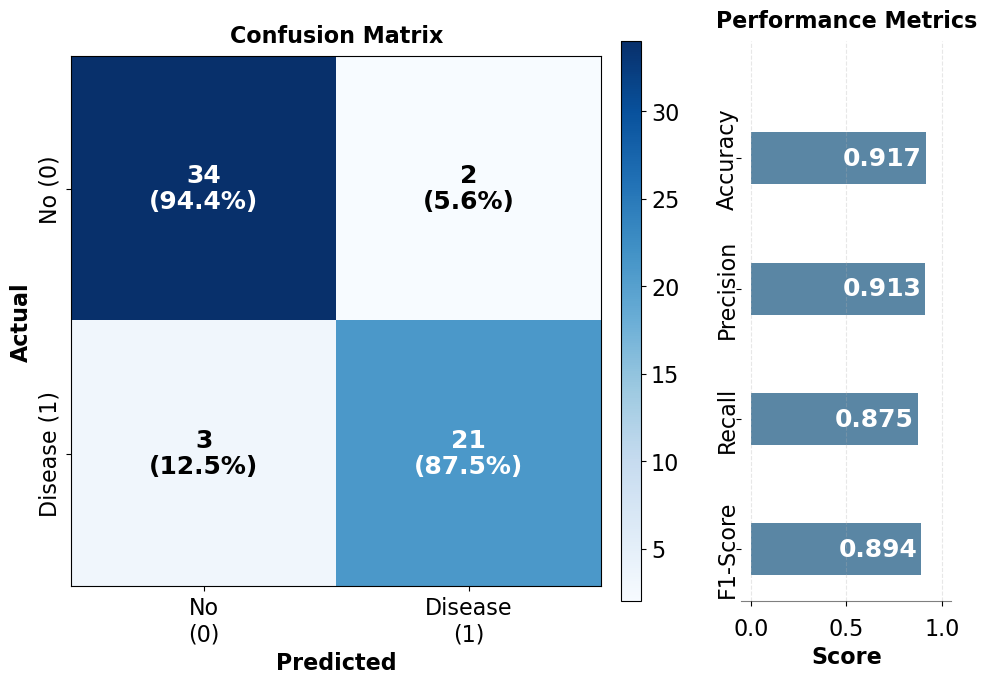

In [30]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [31]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.8125     0.8125     0.91489362 0.72340426 0.85106383]
Mean: 0.8229
Standard Deviation: 0.0622


In [32]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 49.63 seconds
Meta Model Tuning & Training Time: 87.62 seconds
Total SEL-NNML Tuning & Training Time: 137.24 seconds


### **6.2 Multiple Model Evaluation**

The evaluation below compares all models (base models + SEL-NNML) for the selected sampler. To compare models across different samplers, change the `SELECTED_SAMPLER` variable in the cell above.

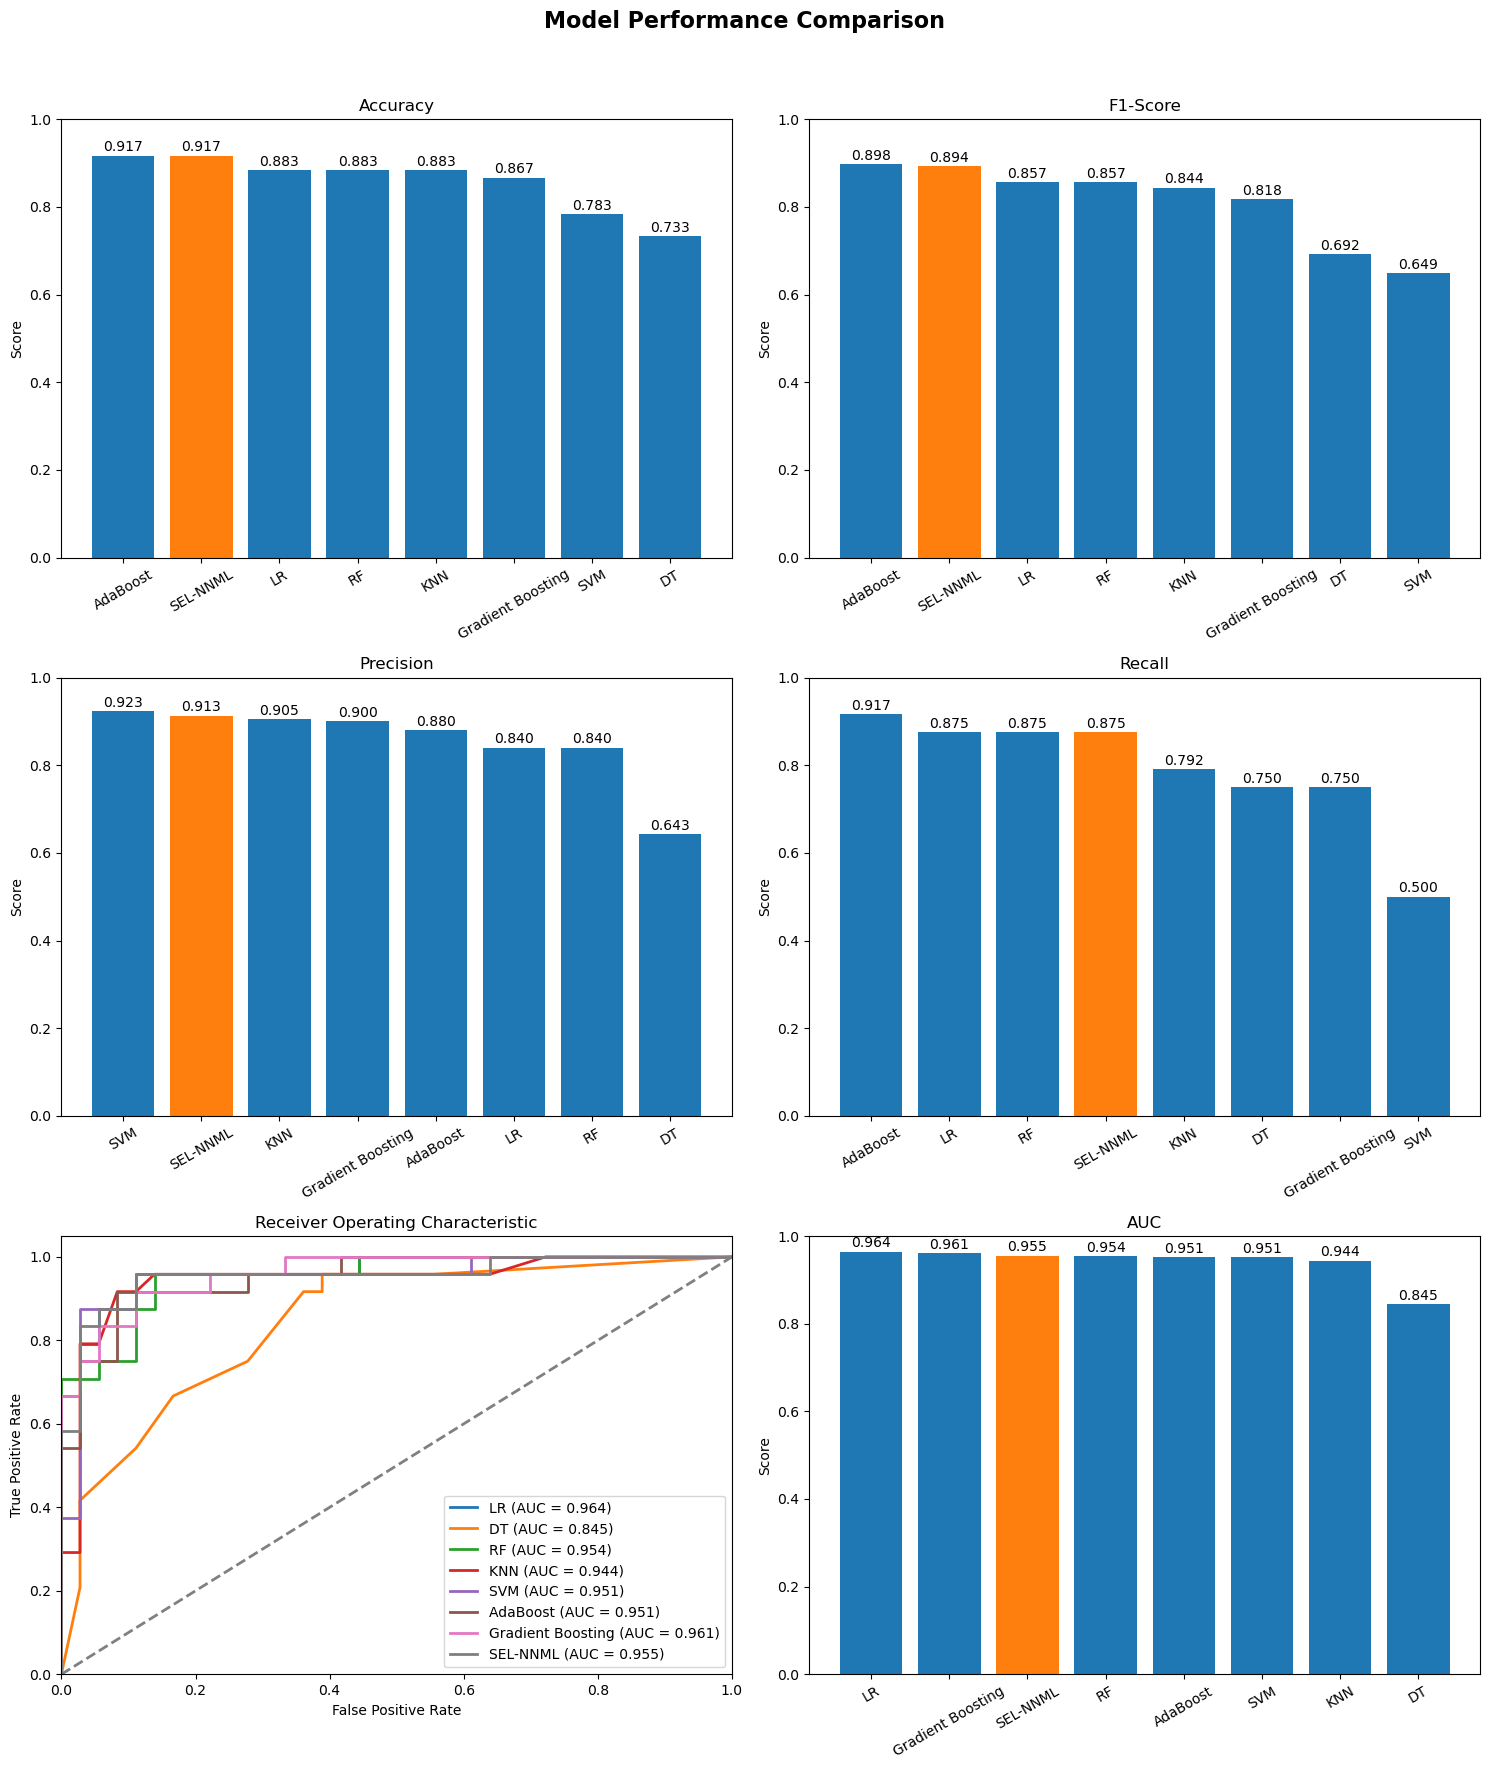

In [33]:
# Use the selected sampler's models for comparison
model_comparison_plot(selected_models, X_test, y_test)

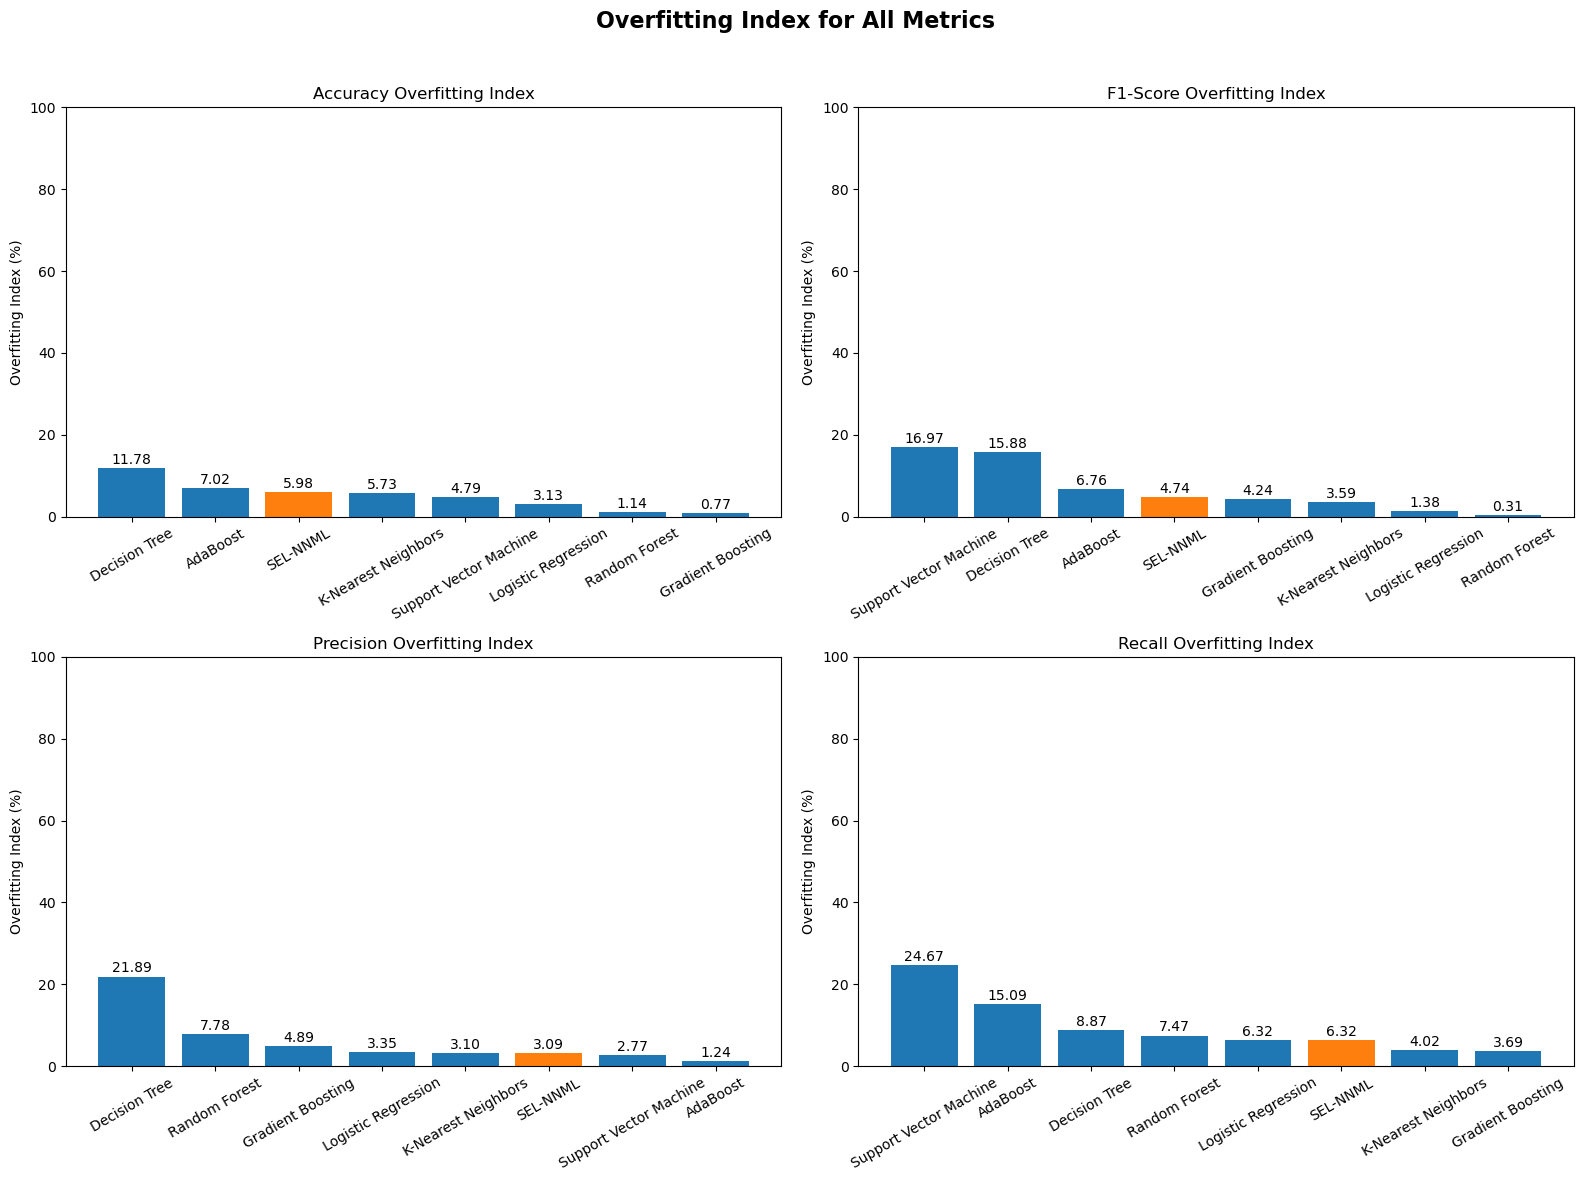

In [34]:
# Use the selected sampler's models for overfitting index comparison
overfitting_index_plot(selected_models, X_train, y_train, X_test, y_test)

In [35]:
# Save feature importance results for all samplers
import os

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    # Set the sampler
    temp_sampler = sampler
    temp_models = all_models[temp_sampler]
    temp_sel_nnml = temp_models['SEL-NNML']
    
    # Calculate permutation importance for this sampler
    print(f"Calculating feature importance for {temp_sampler}...")
    temp_perm_importance = permutation_importance(
        temp_sel_nnml, X_test, y_test,
        n_repeats=30, random_state=42, n_jobs=-1
    )
    
    # Create dataframe
    temp_importance_df = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'Importance Mean': temp_perm_importance.importances_mean,
        'Importance Std': temp_perm_importance.importances_std
    }).sort_values('Importance Mean', ascending=False)
    
    # Save to CSV
    sampler_folder = temp_sampler.lower().replace("-", "")
    os.makedirs(f'../artifacts/ds2/models/{sampler_folder}', exist_ok=True)
    importance_save_path = f'../artifacts/ds2/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    temp_importance_df.to_csv(importance_save_path, index=False)
    print(f"✓ Saved {temp_sampler} feature importance to: {importance_save_path}")

print("\nAll feature importance data saved successfully!")

Calculating feature importance for TPE...
✓ Saved TPE feature importance to: ../artifacts/ds2/models/tpe/sel-nnml_feature_importance.csv
Calculating feature importance for GP...
✓ Saved GP feature importance to: ../artifacts/ds2/models/gp/sel-nnml_feature_importance.csv
Calculating feature importance for CMA-ES...
✓ Saved CMA-ES feature importance to: ../artifacts/ds2/models/cmaes/sel-nnml_feature_importance.csv
Calculating feature importance for QMC...
✓ Saved QMC feature importance to: ../artifacts/ds2/models/qmc/sel-nnml_feature_importance.csv

All feature importance data saved successfully!


### **6.3 Save All Models Metrics (All Samplers)**

This section calculates and saves performance metrics for all models across all samplers. This data will be used for cross-sampler comparisons in the visualization notebook.

In [36]:
# Calculate and save metrics for ALL models from ALL samplers + BASELINE models
from sklearn.metrics import roc_curve, auc
import os

print("Calculating metrics for all models across all samplers + baseline models...")

all_metrics_data = []
all_roc_data = []

# Process baseline models first
print("\nProcessing BASELINE models...")
baseline_models_dict = {
    **{f"{name} (Default)": model for name, model in default_base_models.items()},
    'Stacking + Linear Regression': stacking_lr,
    'Stacking + Default MLP': stacking_mlp
}

for model_name, model in baseline_models_dict.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Get probability predictions for AUC and ROC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store metrics
    all_metrics_data.append({
        'Sampler': 'Baseline',
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc
    })
    
    # Store ROC curve data
    for f, t in zip(fpr, tpr):
        all_roc_data.append({
            'Sampler': 'Baseline',
            'Model': model_name,
            'FPR': f,
            'TPR': t
        })
    
    print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Process optimized models
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    print(f"\nProcessing {sampler} models...")
    models = all_models[sampler]
    
    for model_name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)
        
        # Get probability predictions for AUC and ROC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics
        all_metrics_data.append({
            'Sampler': sampler,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC': roc_auc
        })
        
        # Store ROC curve data
        for f, t in zip(fpr, tpr):
            all_roc_data.append({
                'Sampler': sampler,
                'Model': model_name,
                'FPR': f,
                'TPR': t
            })
        
        print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Create DataFrames
all_metrics_df = pd.DataFrame(all_metrics_data)
all_roc_df = pd.DataFrame(all_roc_data)

# Save to CSV files
os.makedirs('../artifacts/ds2/models', exist_ok=True)
all_metrics_df.to_csv('../artifacts/ds2/models/all_models_metrics.csv', index=False)
all_roc_df.to_csv('../artifacts/ds2/models/all_models_roc_data.csv', index=False)

print(f"\n✅ Saved metrics for {len(all_metrics_data)} model configurations")
print(f"   - Metrics: ../artifacts/ds2/models/all_models_metrics.csv")
print(f"   - ROC Data: ../artifacts/ds2/models/all_models_roc_data.csv")

# Display summary
print("\n" + "="*80)
print("SUMMARY: Top 5 Models by Accuracy")
print("="*80)
display(all_metrics_df.nlargest(5, 'Accuracy')[['Sampler', 'Model', 'Accuracy', 'F1-Score', 'AUC']])

Calculating metrics for all models across all samplers + baseline models...

Processing BASELINE models...
  ✓ Logistic Regression (Default): Acc=0.8833, AUC=0.9514
  ✓ Decision Tree (Default): Acc=0.8167, AUC=0.8333
  ✓ Random Forest (Default): Acc=0.8667, AUC=0.9572
  ✓ K-Nearest Neighbors (Default): Acc=0.8833, AUC=0.9456
  ✓ Support Vector Machine (Default): Acc=0.9000, AUC=0.9560
  ✓ AdaBoost (Default): Acc=0.8833, AUC=0.9086
  ✓ Gradient Boosting (Default): Acc=0.8333, AUC=0.9051
  ✓ Stacking + Linear Regression: Acc=0.8833, AUC=0.9641
  ✓ Stacking + Default MLP: Acc=0.8833, AUC=0.9606

Processing TPE models...
  ✓ Logistic Regression: Acc=0.8833, AUC=0.9641
  ✓ Decision Tree: Acc=0.7333, AUC=0.8449
  ✓ Random Forest: Acc=0.8833, AUC=0.9537
  ✓ K-Nearest Neighbors: Acc=0.8833, AUC=0.9439
  ✓ Support Vector Machine: Acc=0.7833, AUC=0.9514
  ✓ AdaBoost: Acc=0.9167, AUC=0.9514
  ✓ Gradient Boosting: Acc=0.8667, AUC=0.9606
  ✓ SEL-NNML: Acc=0.9167, AUC=0.9549

Processing GP models...

,Sampler,Model,Accuracy,F1-Score,AUC
32,CMA-ES,SEL-NNML,0.933333,0.916667,0.962963
40,QMC,SEL-NNML,0.933333,0.920000,0.943287
14,TPE,AdaBoost,0.916667,0.897959,0.951389
16,TPE,SEL-NNML,0.916667,0.893617,0.954861
22,GP,AdaBoost,0.916667,0.897959,0.951389


---
# **SECTION 7: Statistical Significance Testing**

Perform paired t-tests to compare SEL-NNML (TPE) against all other 12 models using cross-validation.

## **7.1 Prepare All 13 Models for Statistical Testing**

In [37]:
# Collect all 13 models for paired t-test
models_for_ttest = {}

# Add 9 baseline models (7 base learners + 2 stacking)
models_for_ttest.update({
    f"{name} (Default)": model 
    for name, model in default_base_models.items()
})
models_for_ttest['Stacking + Linear Regression'] = stacking_lr
models_for_ttest['Stacking + Default MLP'] = stacking_mlp

# Add 4 optimized SEL-NNML models
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sel_model = all_models[sampler]['SEL-NNML']
    models_for_ttest[f"SEL-NNML ({sampler})"] = sel_model

print("="*80)
print("MODELS PREPARED FOR PAIRED T-TEST")
print("="*80)
print(f"Total models: {len(models_for_ttest)}")
print("\nBaseline Models (9):")
for i, name in enumerate(list(models_for_ttest.keys())[:9], 1):
    print(f"  {i}. {name}")
print("\nOptimized SEL-NNML Models (4):")
for i, name in enumerate(list(models_for_ttest.keys())[9:], 10):
    print(f"  {i}. {name}")
print("="*80)

MODELS PREPARED FOR PAIRED T-TEST
Total models: 13

Baseline Models (9):
  1. Logistic Regression (Default)
  2. Decision Tree (Default)
  3. Random Forest (Default)
  4. K-Nearest Neighbors (Default)
  5. Support Vector Machine (Default)
  6. AdaBoost (Default)
  7. Gradient Boosting (Default)
  8. Stacking + Linear Regression
  9. Stacking + Default MLP

Optimized SEL-NNML Models (4):
  10. SEL-NNML (TPE)
  11. SEL-NNML (GP)
  12. SEL-NNML (CMA-ES)
  13. SEL-NNML (QMC)


## **7.2 Cross-Validation for All Models (10-Fold)**

Run 10-fold stratified cross-validation on all 13 models to generate paired samples for statistical testing.

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time

# Configuration for statistical testing
N_FOLDS_TTEST = 10  # Use 10-fold CV for better statistical power
METRIC = 'accuracy'  # Primary metric for comparison

# Create StratifiedKFold to ensure all models are evaluated on the same folds
skf = StratifiedKFold(n_splits=N_FOLDS_TTEST, shuffle=True, random_state=RANDOM_STATE)

print("="*80)
print(f"RUNNING {N_FOLDS_TTEST}-FOLD CROSS-VALIDATION FOR ALL 13 MODELS")
print("="*80)
print(f"Metric: {METRIC}")
print(f"This will generate {N_FOLDS_TTEST} paired samples for each model...")
print("="*80)
print()

cv_scores = {}
cv_start_time = time.time()

for idx, (name, model) in enumerate(models_for_ttest.items(), 1):
    model_start = time.time()
    print(f"[{idx}/13] Evaluating {name}...", end=" ", flush=True)
    
    scores = cross_val_score(
        model, X_train, y_train, 
        cv=skf, 
        scoring=METRIC,
        n_jobs=N_JOBS
    )
    
    cv_scores[name] = scores
    model_time = time.time() - model_start
    
    print(f"Mean={scores.mean():.4f}, Std={scores.std(ddof=1):.4f} (Time: {model_time:.2f}s)")

total_cv_time = time.time() - cv_start_time

print()
print("="*80)
print(f"✓ Cross-validation completed in {total_cv_time:.2f} seconds ({total_cv_time/60:.2f} minutes)")
print("="*80)

RUNNING 10-FOLD CROSS-VALIDATION FOR ALL 13 MODELS
Metric: accuracy
This will generate 10 paired samples for each model...

[1/13] Evaluating Logistic Regression (Default)... Mean=0.8313, Std=0.0522 (Time: 0.03s)
[2/13] Evaluating Decision Tree (Default)... Mean=0.6841, Std=0.0750 (Time: 0.03s)
[3/13] Evaluating Random Forest (Default)... Mean=0.7763, Std=0.0632 (Time: 0.25s)
[4/13] Evaluating K-Nearest Neighbors (Default)... Mean=0.7937, Std=0.0711 (Time: 0.03s)
[5/13] Evaluating Support Vector Machine (Default)... Mean=0.8230, Std=0.0702 (Time: 0.04s)
[6/13] Evaluating AdaBoost (Default)... Mean=0.8149, Std=0.0626 (Time: 0.11s)
[7/13] Evaluating Gradient Boosting (Default)... Mean=0.7645, Std=0.0851 (Time: 0.15s)
[8/13] Evaluating Stacking + Linear Regression... Mean=0.8149, Std=0.0554 (Time: 2.95s)
[9/13] Evaluating Stacking + Default MLP... Mean=0.8065, Std=0.0585 (Time: 2.97s)
[10/13] Evaluating SEL-NNML (TPE)... Mean=0.8188, Std=0.0862 (Time: 1.49s)
[11/13] Evaluating SEL-NNML (G

## **7.3 Perform Paired t-tests**

Compare SEL-NNML (TPE) against all other 12 models using paired t-tests with Bonferroni correction.

In [39]:
from scipy import stats
import numpy as np

# Define the control/proposed method
CONTROL_MODEL = 'SEL-NNML (TPE)'
ALPHA = 0.05

if CONTROL_MODEL not in cv_scores:
    raise ValueError(f"Control model '{CONTROL_MODEL}' not found in cv_scores")

control_scores = cv_scores[CONTROL_MODEL]
n_comparisons = len(models_for_ttest) - 1  # Exclude comparison with itself

print("="*80)
print(f"PAIRED T-TEST: {CONTROL_MODEL} vs. ALL OTHER MODELS")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Control Mean Accuracy: {control_scores.mean():.4f} ± {control_scores.std(ddof=1):.4f}")
print(f"Number of Comparisons: {n_comparisons}")
print(f"Significance Level (α): {ALPHA}")
print(f"Multiple Testing Correction: Bonferroni (adjusted α = {ALPHA/n_comparisons:.4f})")
print("="*80)
print()

# Perform paired t-tests
results = []

for name, scores in cv_scores.items():
    if name == CONTROL_MODEL:
        continue  # Skip comparing with itself
    
    # Calculate differences (control - other)
    diff = control_scores - scores
    
    # Paired t-test
    t_stat, p_val = stats.ttest_rel(control_scores, scores)
    
    # Cohen's d for paired samples (effect size)
    d = diff.mean() / (diff.std(ddof=1) + 1e-12)
    
    # Bonferroni correction
    p_bonf = min(1.0, p_val * n_comparisons)
    
    # Significance
    is_significant = p_bonf < ALPHA
    
    results.append({
        'Model': name,
        'Control Mean': control_scores.mean(),
        'Other Mean': scores.mean(),
        'Mean Difference': diff.mean(),
        't-statistic': t_stat,
        'p-value': p_val,
        'p-value (Bonferroni)': p_bonf,
        "Cohen's d": d,
        'Significant (α=0.05)': is_significant
    })

# Create DataFrame and sort by p-value
results_df = pd.DataFrame(results).sort_values('p-value (Bonferroni)')

print(f"{'Model':<40} {'Mean Diff':<12} {'t-stat':<10} {'p-value':<12} {'p (Bonf.)':<12} {'Sig?':<8}")
print("-"*100)

for _, row in results_df.iterrows():
    sig_marker = "✓" if row['Significant (α=0.05)'] else "✗"
    print(f"{row['Model']:<40} {row['Mean Difference']:>11.4f} {row['t-statistic']:>10.3f} "
          f"{row['p-value']:>11.4f} {row['p-value (Bonferroni)']:>11.4f} {sig_marker:>8}")

print("="*100)

PAIRED T-TEST: SEL-NNML (TPE) vs. ALL OTHER MODELS
Control Model: SEL-NNML (TPE)
Control Mean Accuracy: 0.8188 ± 0.0862
Number of Comparisons: 12
Significance Level (α): 0.05
Multiple Testing Correction: Bonferroni (adjusted α = 0.0042)

Model                                    Mean Diff    t-stat     p-value      p (Bonf.)    Sig?    
----------------------------------------------------------------------------------------------------
Decision Tree (Default)                       0.1348      4.412      0.0017      0.0203        ✓
Logistic Regression (Default)                -0.0125     -0.812      0.4376      1.0000        ✗
Random Forest (Default)                       0.0426      1.749      0.1142      1.0000        ✗
K-Nearest Neighbors (Default)                 0.0252      1.934      0.0852      1.0000        ✗
Support Vector Machine (Default)             -0.0042     -0.421      0.6836      1.0000        ✗
AdaBoost (Default)                            0.0040      0.220      0.8307 

## **7.4 Summary and Interpretation**

In [40]:
# Summary statistics
sig_count = results_df['Significant (α=0.05)'].sum()
better_count = (results_df['Mean Difference'] > 0).sum()
worse_count = (results_df['Mean Difference'] < 0).sum()

sig_better = results_df[(results_df['Significant (α=0.05)']) & (results_df['Mean Difference'] > 0)]
sig_worse = results_df[(results_df['Significant (α=0.05)']) & (results_df['Mean Difference'] < 0)]

print()
print("="*80)
print("STATISTICAL SIGNIFICANCE TEST SUMMARY")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Control Mean Accuracy: {control_scores.mean():.4f} ± {control_scores.std(ddof=1):.4f}")
print()
print(f"Total Comparisons: {n_comparisons}")
print(f"Significance Threshold (Bonferroni-corrected): p < {ALPHA}")
print()
print("Results:")
print(f"  ✓ Significantly Better Than:  {len(sig_better)}/{n_comparisons} models")
print(f"  ✗ Significantly Worse Than:   {len(sig_worse)}/{n_comparisons} models")
print(f"  ≈ No Significant Difference:  {n_comparisons - sig_count}/{n_comparisons} models")
print()

if len(sig_better) > 0:
    print("Models Significantly Outperformed:")
    for _, row in sig_better.iterrows():
        print(f"  • {row['Model']:<45} (Δ = +{row['Mean Difference']:.4f}, p = {row['p-value (Bonferroni)']:.4f})")

if len(sig_worse) > 0:
    print()
    print("Models That Significantly Outperformed Control:")
    for _, row in sig_worse.iterrows():
        print(f"  • {row['Model']:<45} (Δ = {row['Mean Difference']:.4f}, p = {row['p-value (Bonferroni)']:.4f})")

print("="*80)
print()

# Display full results table
print("DETAILED RESULTS TABLE:")
print("="*80)
display(results_df)


STATISTICAL SIGNIFICANCE TEST SUMMARY
Control Model: SEL-NNML (TPE)
Control Mean Accuracy: 0.8188 ± 0.0862

Total Comparisons: 12
Significance Threshold (Bonferroni-corrected): p < 0.05

Results:
  ✓ Significantly Better Than:  1/12 models
  ✗ Significantly Worse Than:   0/12 models
  ≈ No Significant Difference:  11/12 models

Models Significantly Outperformed:
  • Decision Tree (Default)                       (Δ = +0.1348, p = 0.0203)

DETAILED RESULTS TABLE:


,Model,Control Mean,Other Mean,Mean Difference,t-statistic,p-value,p-value (Bonferroni),Cohen's d,Significant (α=0.05)
1,Decision Tree (Default),0.818841,0.684058,1.347826e-01,4.411860e+00,0.001691,0.020292,1.395153e+00,True
0,Logistic Regression (Default),0.818841,0.831341,-1.250000e-02,-8.122395e-01,0.437610,1.000000,-2.568527e-01,False
2,Random Forest (Default),0.818841,0.776268,4.257246e-02,1.748970e+00,0.114229,1.000000,5.530730e-01,False
3,K-Nearest Neighbors (Default),0.818841,0.793659,2.518116e-02,1.933604e+00,0.085179,1.000000,6.114593e-01,False
4,Support Vector Machine (Default),0.818841,0.823007,-4.166667e-03,-4.210057e-01,0.683626,1.000000,-1.331337e-01,False
5,AdaBoost (Default),0.818841,0.814855,3.985507e-03,2.201027e-01,0.830703,1.000000,6.960260e-02,False
6,Gradient Boosting (Default),0.818841,0.764493,5.434783e-02,1.781358e+00,0.108543,1.000000,5.633148e-01,False
7,Stacking + Linear Regression,0.818841,0.814855,3.985507e-03,2.483310e-01,0.809452,1.000000,7.852915e-02,False
8,Stacking + Default MLP,0.818841,0.806522,1.231884e-02,7.348024e-01,0.481166,1.000000,2.323649e-01,False
9,SEL-NNML (GP),0.818841,0.823007,-4.166667e-03,-1.000000e+00,0.343436,1.000000,-3.162278e-01,False


## **7.5 Save Results**

In [41]:
# Save paired t-test results
output_dir = '../artifacts/ds2/models'
os.makedirs(output_dir, exist_ok=True)

# Save main results
results_path = os.path.join(output_dir, 'paired_ttest_results.csv')
results_df.to_csv(results_path, index=False)
print(f"✓ Paired t-test results saved to: {results_path}")

# Save CV scores for reproducibility
cv_scores_data = []
for model_name, scores in cv_scores.items():
    for fold_idx, score in enumerate(scores, 1):
        cv_scores_data.append({
            'Model': model_name,
            'Fold': fold_idx,
            'Accuracy': score
        })

cv_scores_df = pd.DataFrame(cv_scores_data)
cv_scores_path = os.path.join(output_dir, 'cv_scores_for_ttest.csv')
cv_scores_df.to_csv(cv_scores_path, index=False)
print(f"✓ Cross-validation scores saved to: {cv_scores_path}")

# Save summary statistics
summary_data = {
    'Control_Model': CONTROL_MODEL,
    'Control_Mean_Accuracy': control_scores.mean(),
    'Control_Std_Accuracy': control_scores.std(ddof=1),
    'Total_Comparisons': n_comparisons,
    'Significantly_Better': len(sig_better),
    'Significantly_Worse': len(sig_worse),
    'No_Significant_Difference': n_comparisons - sig_count,
    'Significance_Level': ALPHA,
    'CV_Folds': N_FOLDS_TTEST,
    'Metric': METRIC
}

summary_df = pd.DataFrame([summary_data])
summary_path = os.path.join(output_dir, 'ttest_summary.csv')
summary_df.to_csv(summary_path, index=False)
print(f"✓ Summary statistics saved to: {summary_path}")

print()
print("="*80)
print("✅ STATISTICAL SIGNIFICANCE TESTING COMPLETE")
print("="*80)

✓ Paired t-test results saved to: ../artifacts/ds2/models\paired_ttest_results.csv
✓ Cross-validation scores saved to: ../artifacts/ds2/models\cv_scores_for_ttest.csv
✓ Summary statistics saved to: ../artifacts/ds2/models\ttest_summary.csv

✅ STATISTICAL SIGNIFICANCE TESTING COMPLETE


---
# **SECTION 8: McNemar's Test**

Perform McNemar's test to compare prediction disagreements between SEL-NNML (TPE) and other models on the test set. This test examines whether models make systematically different errors on specific instances.

## **8.1 Generate Predictions on Test Set**

Generate predictions from all 13 models on the test set for McNemar's test.

In [42]:
# Generate predictions from all 13 models on test set
test_predictions = {}

print("="*80)
print("GENERATING TEST SET PREDICTIONS FOR MCNEMAR'S TEST")
print("="*80)
print(f"Test set size: {len(y_test)}")
print()

for idx, (name, model) in enumerate(models_for_ttest.items(), 1):
    print(f"[{idx}/13] Predicting with {name}...", end=" ", flush=True)
    
    # All models (baseline and optimized) were trained on the same X_train
    # (which has both scaled numeric features and boolean features merged)
    # So they all need X_test (not X_test_scaled which only has numeric features)
    y_pred = model.predict(X_test)
    
    test_predictions[name] = y_pred
    accuracy = (y_pred == y_test).sum() / len(y_test)
    print(f"Accuracy: {accuracy:.4f}")

print()
print("="*80)
print(f"✓ Generated predictions for all {len(test_predictions)} models")
print("="*80)

GENERATING TEST SET PREDICTIONS FOR MCNEMAR'S TEST
Test set size: 60

[1/13] Predicting with Logistic Regression (Default)... Accuracy: 0.8833
[2/13] Predicting with Decision Tree (Default)... Accuracy: 0.8167
[3/13] Predicting with Random Forest (Default)... Accuracy: 0.8667
[4/13] Predicting with K-Nearest Neighbors (Default)... Accuracy: 0.8833
[5/13] Predicting with Support Vector Machine (Default)... Accuracy: 0.9000
[6/13] Predicting with AdaBoost (Default)... Accuracy: 0.8833
[7/13] Predicting with Gradient Boosting (Default)... Accuracy: 0.8333
[8/13] Predicting with Stacking + Linear Regression... Accuracy: 0.8833
[9/13] Predicting with Stacking + Default MLP... Accuracy: 0.8833
[10/13] Predicting with SEL-NNML (TPE)... Accuracy: 0.9167
[11/13] Predicting with SEL-NNML (GP)... Accuracy: 0.9167
[12/13] Predicting with SEL-NNML (CMA-ES)... Accuracy: 0.9333
[13/13] Predicting with SEL-NNML (QMC)... Accuracy: 0.9333

✓ Generated predictions for all 13 models


## **8.2 Perform McNemar's Tests**

Compare SEL-NNML (TPE) against all other 12 models using McNemar's test.

In [43]:
from scipy.stats import chi2

def mcnemar_test(y_true, y_pred_a, y_pred_b):
    """
    Perform McNemar's test for two classifiers.
    
    Returns:
        - contingency table (2x2)
        - chi-square statistic
        - p-value
    """
    # Create contingency table
    # both_correct: both A and B correct
    # a_correct_b_wrong: A correct, B wrong
    # a_wrong_b_correct: A wrong, B correct
    # both_wrong: both A and B wrong
    
    both_correct = ((y_pred_a == y_true) & (y_pred_b == y_true)).sum()
    a_correct_b_wrong = ((y_pred_a == y_true) & (y_pred_b != y_true)).sum()
    a_wrong_b_correct = ((y_pred_a != y_true) & (y_pred_b == y_true)).sum()
    both_wrong = ((y_pred_a != y_true) & (y_pred_b != y_true)).sum()
    
    # Contingency table
    table = np.array([[both_correct, a_correct_b_wrong],
                      [a_wrong_b_correct, both_wrong]])
    
    # McNemar's test statistic with continuity correction
    b = a_correct_b_wrong
    c = a_wrong_b_correct
    
    # Chi-square test statistic (with continuity correction)
    if b + c > 0:
        chi2_stat = (abs(b - c) - 1)**2 / (b + c)
    else:
        chi2_stat = 0.0
    
    # p-value from chi-square distribution (df=1)
    p_value = 1 - chi2.cdf(chi2_stat, df=1)
    
    return table, chi2_stat, p_value, b, c

# Control model
control_pred = test_predictions[CONTROL_MODEL]

print("="*80)
print(f"MCNEMAR'S TEST: {CONTROL_MODEL} vs. ALL OTHER MODELS")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Test Set Size: {len(y_test)}")
print(f"Significance Level: α = {ALPHA}")
print("="*80)
print()

mcnemar_results = []

for name, pred in test_predictions.items():
    if name == CONTROL_MODEL:
        continue
    
    table, chi2_stat, p_value, b, c = mcnemar_test(y_test.values, control_pred, pred)
    
    # Bonferroni correction
    p_bonf = min(1.0, p_value * n_comparisons)
    is_significant = p_bonf < ALPHA
    
    mcnemar_results.append({
        'Model': name,
        'Both Correct': table[0, 0],
        'Control Right, Other Wrong': b,
        'Control Wrong, Other Right': c,
        'Both Wrong': table[1, 1],
        'Chi-Square': chi2_stat,
        'p-value': p_value,
        'p-value (Bonferroni)': p_bonf,
        'Significant (α=0.05)': is_significant
    })

# Create DataFrame
mcnemar_df = pd.DataFrame(mcnemar_results).sort_values('p-value (Bonferroni)')

print(f"{'Model':<40} {'b (C✓O✗)':<12} {'c (C✗O✓)':<12} {'χ²':<10} {'p-value':<12} {'p (Bonf.)':<12} {'Sig?':<8}")
print("-"*110)

for _, row in mcnemar_df.iterrows():
    sig_marker = "✓" if row['Significant (α=0.05)'] else "✗"
    print(f"{row['Model']:<40} {row['Control Right, Other Wrong']:>11} {row['Control Wrong, Other Right']:>11} "
          f"{row['Chi-Square']:>10.3f} {row['p-value']:>11.4f} {row['p-value (Bonferroni)']:>11.4f} {sig_marker:>8}")

print("="*110)

MCNEMAR'S TEST: SEL-NNML (TPE) vs. ALL OTHER MODELS
Control Model: SEL-NNML (TPE)
Test Set Size: 60
Significance Level: α = 0.05

Model                                    b (C✓O✗)     c (C✗O✓)     χ²         p-value      p (Bonf.)    Sig?    
--------------------------------------------------------------------------------------------------------------
Logistic Regression (Default)                      3           1      0.250      0.6171      1.0000        ✗
Decision Tree (Default)                           10           4      1.786      0.1814      1.0000        ✗
Random Forest (Default)                            4           1      0.800      0.3711      1.0000        ✗
K-Nearest Neighbors (Default)                      4           2      0.167      0.6831      1.0000        ✗
Support Vector Machine (Default)                   2           1      0.000      1.0000      1.0000        ✗
AdaBoost (Default)                                 5           3      0.125      0.7237      1.0000  

## **8.3 Contingency Table Visualization**

Visualize the contingency tables for significant comparisons.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 5 most significant comparisons (or all if fewer than 5)
sig_comparisons = mcnemar_df[mcnemar_df['Significant (α=0.05)']].head(5)

if len(sig_comparisons) > 0:
    n_plots = len(sig_comparisons)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    for idx, (_, row) in enumerate(sig_comparisons.iterrows()):
        ax = axes[idx]
        
        # Create contingency table
        table_data = np.array([
            [row['Both Correct'], row['Control Right, Other Wrong']],
            [row['Control Wrong, Other Right'], row['Both Wrong']]
        ])
        
        # Plot heatmap
        sns.heatmap(table_data, annot=True, fmt='d', cmap='Blues', 
                    cbar=True, ax=ax, annot_kws={'size': 14, 'weight': 'bold'},
                    xticklabels=['Other Correct', 'Other Wrong'],
                    yticklabels=['Control Correct', 'Control Wrong'])
        
        ax.set_title(f"{CONTROL_MODEL} vs. {row['Model']}\n"
                     f"χ²={row['Chi-Square']:.3f}, p={row['p-value (Bonferroni)']:.4f}",
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Other Model', fontsize=10, fontweight='bold')
        ax.set_ylabel('Control Model', fontsize=10, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Displayed contingency tables for {len(sig_comparisons)} significant comparison(s)")
else:
    print("\n⚠ No significant comparisons found (p < 0.05 after Bonferroni correction)")
    print("   Contingency table visualization skipped.")


⚠ No significant comparisons found (p < 0.05 after Bonferroni correction)
   Contingency table visualization skipped.


## **8.4 Summary and Interpretation**

In [45]:
# Summary statistics
sig_count_mcnemar = mcnemar_df['Significant (α=0.05)'].sum()

# Models where control is significantly better (b > c and significant)
control_better = mcnemar_df[
    (mcnemar_df['Significant (α=0.05)']) & 
    (mcnemar_df['Control Right, Other Wrong'] > mcnemar_df['Control Wrong, Other Right'])
]

# Models where other is significantly better (c > b and significant)
control_worse = mcnemar_df[
    (mcnemar_df['Significant (α=0.05)']) & 
    (mcnemar_df['Control Wrong, Other Right'] > mcnemar_df['Control Right, Other Wrong'])
]

print()
print("="*80)
print("MCNEMAR'S TEST SUMMARY")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Test Set Size: {len(y_test)}")
print(f"Total Comparisons: {n_comparisons}")
print(f"Significance Level: α = {ALPHA} (Bonferroni-corrected)")
print()
print("Results:")
print(f"  ✓ Significantly Different From:   {sig_count_mcnemar}/{n_comparisons} models")
print(f"    - Control Better:                {len(control_better)}")
print(f"    - Control Worse:                 {len(control_worse)}")
print(f"  ≈ No Significant Difference:       {n_comparisons - sig_count_mcnemar}/{n_comparisons} models")
print()

if len(control_better) > 0:
    print("Models Significantly Outperformed by Control:")
    for _, row in control_better.iterrows():
        b = row['Control Right, Other Wrong']
        c = row['Control Wrong, Other Right']
        print(f"  • {row['Model']:<45} (b={b}, c={c}, χ²={row['Chi-Square']:.3f}, p={row['p-value (Bonferroni)']:.4f})")

if len(control_worse) > 0:
    print()
    print("Models That Significantly Outperformed Control:")
    for _, row in control_worse.iterrows():
        b = row['Control Right, Other Wrong']
        c = row['Control Wrong, Other Right']
        print(f"  • {row['Model']:<45} (b={b}, c={c}, χ²={row['Chi-Square']:.3f}, p={row['p-value (Bonferroni)']:.4f})")

print()
print("Interpretation:")
print("  - 'b' (Control Right, Other Wrong): Instances where control is correct but other model is wrong")
print("  - 'c' (Control Wrong, Other Right): Instances where control is wrong but other model is correct")
print("  - If b >> c: Control makes fewer errors → control is better")
print("  - If c >> b: Other model makes fewer errors → other model is better")
print("  - If b ≈ c: Models make different but equal errors → no significant difference")
print("="*80)
print()

# Display full results table
print("DETAILED RESULTS TABLE:")
print("="*80)
display(mcnemar_df)


MCNEMAR'S TEST SUMMARY
Control Model: SEL-NNML (TPE)
Test Set Size: 60
Total Comparisons: 12
Significance Level: α = 0.05 (Bonferroni-corrected)

Results:
  ✓ Significantly Different From:   0/12 models
    - Control Better:                0
    - Control Worse:                 0
  ≈ No Significant Difference:       12/12 models


Interpretation:
  - 'b' (Control Right, Other Wrong): Instances where control is correct but other model is wrong
  - 'c' (Control Wrong, Other Right): Instances where control is wrong but other model is correct
  - If b >> c: Control makes fewer errors → control is better
  - If c >> b: Other model makes fewer errors → other model is better
  - If b ≈ c: Models make different but equal errors → no significant difference

DETAILED RESULTS TABLE:


,Model,Both Correct,"Control Right, Other Wrong","Control Wrong, Other Right",Both Wrong,Chi-Square,p-value,p-value (Bonferroni),Significant (α=0.05)
0,Logistic Regression (Default),52,3,1,4,0.250000,0.617075,1.0,False
1,Decision Tree (Default),45,10,4,1,1.785714,0.181449,1.0,False
2,Random Forest (Default),51,4,1,4,0.800000,0.371093,1.0,False
3,K-Nearest Neighbors (Default),51,4,2,3,0.166667,0.683091,1.0,False
4,Support Vector Machine (Default),53,2,1,4,0.000000,1.000000,1.0,False
5,AdaBoost (Default),50,5,3,2,0.125000,0.723674,1.0,False
6,Gradient Boosting (Default),48,7,2,3,1.777778,0.182422,1.0,False
7,Stacking + Linear Regression,52,3,1,4,0.250000,0.617075,1.0,False
8,Stacking + Default MLP,52,3,1,4,0.250000,0.617075,1.0,False
9,SEL-NNML (GP),55,0,0,5,0.000000,1.000000,1.0,False


## **8.5 Save Results**

In [46]:
# Save McNemar's test results
mcnemar_results_path = os.path.join(output_dir, 'mcnemar_test_results.csv')
mcnemar_df.to_csv(mcnemar_results_path, index=False)
print(f"✓ McNemar's test results saved to: {mcnemar_results_path}")

# Save test predictions for reproducibility
test_pred_data = []
for model_name, predictions in test_predictions.items():
    for idx, pred in enumerate(predictions):
        test_pred_data.append({
            'Model': model_name,
            'Instance_Index': idx,
            'Prediction': pred,
            'True_Label': y_test.iloc[idx]
        })

test_pred_df = pd.DataFrame(test_pred_data)
test_pred_path = os.path.join(output_dir, 'test_predictions_for_mcnemar.csv')
test_pred_df.to_csv(test_pred_path, index=False)
print(f"✓ Test predictions saved to: {test_pred_path}")

# Save McNemar summary statistics
mcnemar_summary = {
    'Control_Model': CONTROL_MODEL,
    'Test_Set_Size': len(y_test),
    'Total_Comparisons': n_comparisons,
    'Significant_Differences': sig_count_mcnemar,
    'Control_Better': len(control_better),
    'Control_Worse': len(control_worse),
    'No_Significant_Difference': n_comparisons - sig_count_mcnemar,
    'Significance_Level': ALPHA
}

mcnemar_summary_df = pd.DataFrame([mcnemar_summary])
mcnemar_summary_path = os.path.join(output_dir, 'mcnemar_summary.csv')
mcnemar_summary_df.to_csv(mcnemar_summary_path, index=False)
print(f"✓ McNemar summary statistics saved to: {mcnemar_summary_path}")

print()
print("="*80)
print("✅ MCNEMAR'S TEST COMPLETE")
print("="*80)

✓ McNemar's test results saved to: ../artifacts/ds2/models\mcnemar_test_results.csv
✓ Test predictions saved to: ../artifacts/ds2/models\test_predictions_for_mcnemar.csv
✓ McNemar summary statistics saved to: ../artifacts/ds2/models\mcnemar_summary.csv

✅ MCNEMAR'S TEST COMPLETE
